## 賃料についてのドメイン知識


- https://lobotomy-project.org/marketpricerent/
- https://ameblo.jp/enjoytokyolovelivelife/entry-11084920720.html


## パッケージインポート

In [4]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib
font = {'family': 'Yu Mincho'}
matplotlib.rc('font', **font)

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)

import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from tqdm import tqdm

import os
import gc
print(os.listdir("../../input"))
print(os.listdir("../../submit"))

['data', 'line.csv', 'location 保存用.txt', 'location.csv', 'location.txt', 'station 保存用.txt', 'station.csv', 'station.txt', 'test.csv', 'test.pkl', 'tokyo23', 'train.csv', 'train.pkl']
['feature.csv', 'sample_submit.csv', 'submit1.csv', 'submit10.csv', 'submit11.csv', 'submit12.csv', 'submit13.csv', 'submit14.csv', 'submit15.csv', 'submit16.csv', 'submit17.csv', 'submit18.csv', 'submit19.csv', 'submit2.csv', 'submit20.csv', 'submit21.csv', 'submit3.csv', 'submit4.csv', 'submit5.csv', 'submit6.csv', 'submit7.csv', 'submit8.csv', 'submit9.csv', '特徴量について.xlsx']


## データ読み込み

In [5]:
train = pd.read_csv('../../input/train.csv')
test = pd.read_csv('../../input/test.csv')
submit = pd.read_csv('../../submit/sample_submit.csv')

In [6]:
train = train.rename(columns={'賃料':'target','所在地':'location','アクセス':'access',
                              '間取り':'floor_plan','築年数':'age','方角':'direction','面積':'area','所在階':'Floor',
                              'バス・トイレ':'Bath_Toilet','キッチン':'kitchen','放送・通信':'broadcast','室内設備':'facilities',
                              '駐車場':'parking','周辺環境':'env','建物構造':'structure','契約期間':'year'})

test = test.rename(columns={'所在地':'location','アクセス':'access',
                              '間取り':'floor_plan','築年数':'age','方角':'direction','面積':'area','所在階':'Floor',
                              'バス・トイレ':'Bath_Toilet','キッチン':'kitchen','放送・通信':'broadcast','室内設備':'facilities',
                              '駐車場':'parking','周辺環境':'env','建物構造':'structure','契約期間':'year'})

## データ概要

In [7]:
## データの概要
def resumetable(df):
    print(f'Dataset Shape:{df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary ['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name']==name, 'Entoropy'] = round(stats.entropy(df[name].value_counts(normalize=True),base=2),2)
        
    return summary

## 欠損値
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent],axis=1, keys=['Total','Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return np.transpose(tt)

## 外れ値
def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('lower : ', lower, ' upper : ',upper)
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [8]:
print('訓練データ : ', train.shape)
print('テストデータ : ',test.shape)

訓練データ :  (31470, 17)
テストデータ :  (31262, 16)


In [9]:
resumetable(train)

Dataset Shape:(31470, 17)


Name  dtypes  Missing  Uniques  \
0            id   int64        0    31470   
1        target   int64        0      871   
2      location  object        0    11333   
3        access  object        0    24172   
4    floor_plan  object        0       30   
5           age  object        0      746   
6     direction  object     2749        8   
7          area  object        0     5739   
8         Floor  object        0     1032   
9   Bath_Toilet  object      329      360   
10      kitchen  object      621      381   
11    broadcast  object     3440      139   
12   facilities  object       82     6220   
13      parking  object     5287     3911   
14          env  object     9432    17864   
15    structure  object        0       10   
16         year  object     7120       66   

                                          First Value  \
0                                                   1   
1                                               75000   
2                                         東京都北区滝野川３丁目   
3   都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...   
4                                                  1K   
5                                               9年9ヶ月   
6                                                  南東   
7                                             20.01m2   
8                                             1階／12階建   
9    専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座   
10                    ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯   
11                 インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ   
12  エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...   
13                                            駐輪場\t空有   
14  【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...   
15                                       RC（鉄筋コンクリート）   
16                                                2年間   

                                         Second Value  \
0                                                   2   
1                                               76000   
2                                         東京都中央区月島３丁目   
3   都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...   
4                                                  1R   
5                                             44年10ヶ月   
6                                                 NaN   
7                                              16.5m2   
8                                             5階／10階建   
9                               専用トイレ／\tシャワー／\t温水洗浄便座   
10                            ガスコンロ／\tシステムキッチン\t／\t給湯   
11                                          インターネット対応   
12  エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...   
13                         駐輪場\t空有\t駐車場\t無\tバイク置き場\t無   
14                                       【スーパー】 1283m   
15                                                鉄骨造   
16                                                2年間   

                                          Third Value  Entoropy  
0                                                   3     14.94  
1                                              110000      7.93  
2                                         東京都渋谷区笹塚２丁目     12.62  
3   京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...     14.26  
4                                                  1K      2.77  
5                                               8年6ヶ月      8.56  
6                                                   南      2.73  
7                                             22.05m2     11.50  
8                                            12階／15階建      6.35  
9   専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...      5.77  
10                    ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯      5.53  
11               インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ      5.34  
12  エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...     10.17  
13  駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m      7.89  
14  【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m     13.87  
15                                       RC（鉄筋コンクリート）      1.91  
16                      

In [10]:
resumetable(test)

Dataset Shape:(31262, 16)


Name  dtypes  Missing  Uniques  \
0            id   int64        0    31262   
1      location  object        0    11191   
2        access  object        0    24173   
3    floor_plan  object        0       37   
4           age  object        0      734   
5     direction  object     2808        8   
6          area  object        0     5746   
7         Floor  object        1     1020   
8   Bath_Toilet  object      320      353   
9       kitchen  object      635      379   
10    broadcast  object     3454      144   
11   facilities  object       73     6289   
12      parking  object     5356     3839   
13          env  object     9241    17972   
14    structure  object        0       11   
15         year  object     6981       58   

                                          First Value  \
0                                               31471   
1                                    東京都世田谷区深沢５丁目1-27   
2   東急大井町線\t等々力駅\t徒歩15分\t\t東急田園都市線\t桜新町駅\t徒歩24分\t\...   
3                                                2LDK   
4                                              49年0ヶ月   
5                                                   南   
6                                             50.22m2   
7                                              8階／8階建   
8   専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t温水洗浄便座／...   
9            ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\tL字キッチン   
10                                          インターネット対応   
11  エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\tエレベーター\t公営水...   
12                         駐輪場\t空有\t駐車場\t無\tバイク置き場\t無   
13  【コンビニ】 74m\t【スーパー】 215m\t【病院】 313m\t【小学校】 219m...   
14                                                鉄骨造   
15                                                NaN   

                                         Second Value  \
0                                               31472   
1                                     東京都目黒区八雲１丁目11-8   
2   東急東横線\t都立大学駅\t徒歩6分\t\t東急東横線\t自由が丘駅\t徒歩17分\t\t東...   
3                                                  1R   
4                                               0年2ヶ月   
5                                                  南東   
6                                             20.88m2   
7                                              3階／4階建   
8   専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...   
9                     ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯   
10         インターネット対応／\tCSアンテナ／\tBSアンテナ／\tインターネット使用料無料   
11  エアコン付\tシューズボックス／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水／...   
12    駐車場\t近隣\t34,000円(税込)\t距離200m\t駐輪場\t無\tバイク置き場\t無   
13  【スーパー】 128m\t【スーパー】 313m\t【コンビニ】 374m\t【コンビニ】 ...   
14                                       RC（鉄筋コンクリート）   
15                                                2年間   

                                          Third Value  Entoropy  
0                                               31473     14.93  
1                                   東京都豊島区池袋本町２丁目22-2     12.61  
2   東武東上線\t北池袋駅\t徒歩10分\t\t埼京線\t板橋駅\t徒歩16分\t\t山手線\t...     14.28  
3                                                  1K      2.79  
4                                              23年4ヶ月      8.58  
5                                                  南東      2.73  
6                                             26.93m2     11.50  
7                                              1階／4階建      6.35  
8              専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座      5.80  
9                                          ガスコンロ／\t給湯      5.54  
10                          インターネット対応／\t光ファイバー／\tCATV      5.35  
11  エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t2面採光／\t室内洗濯...     10.19  
12  駐車場\t空有\t5,000円(税込)\t(敷金あり\t1ヶ月)\t駐輪場\t空有\tバイク...      7.86  
13  【スーパー】 529m\t【スーパー】 810m\t【コンビニ】 316m\t【コンビニ】 ...     13.90  
14                                                鉄骨造      1.92  
15                                                2年間      0.56

In [11]:
## 欠損値を埋める
train = train.fillna('-')
test = test.fillna('-')

## 特徴量について

In [12]:
train.describe()

id        target
count  31470.000000  3.147000e+04
mean   15735.500000  1.182903e+05
std     9084.750822  7.374880e+04
min        1.000000  2.500000e+04
25%     7868.250000  7.600000e+04
50%    15735.500000  1.020000e+05
75%    23602.750000  1.360000e+05
max    31470.000000  2.500000e+06

In [13]:
test.describe()

id
count  31262.000000
mean   47101.500000
std     9024.706394
min    31471.000000
25%    39286.250000
50%    47101.500000
75%    54916.750000
max    62732.000000

### 賃料

In [14]:
CalcOutliers(train['target'])

lower :  -102952.58921692356  upper :  339533.2020545467
Identified lowest outliers: 0
Identified upper outliers: 437
Total outlier observations: 437
Non-outlier observations: 31033
Total percentual of Outliers:  1.4082


In [15]:
train.query('target>339533').head()

id  target          location  \
22    23  346000        東京都中央区佃１丁目   
171  172  415000      東京都渋谷区恵比寿４丁目   
242  243  340000       東京都中央区月島１丁目   
258  259  468000      東京都中央区勝どき６丁目   
274  275  650000  東京都品川区上大崎３丁目1-30   

                                                access floor_plan     age  \
22   有楽町線\t月島駅\t徒歩6分\t\t京葉線(東京－蘇我)\t越中島駅\t徒歩11分\t\t...       2LDK  30年4ヶ月   
171  山手線\t恵比寿駅\t徒歩8分\t\t山手線\t目黒駅\t徒歩14分\t\t日比谷線\t広尾...       2LDK  25年0ヶ月   
242  有楽町線\t月島駅\t徒歩1分\t\t都営大江戸線\t勝どき駅\t徒歩10分\t\t京葉線越...       3LDK  16年0ヶ月   
258  都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩14分\t\t日比谷線...       2LDK  11年7ヶ月   
274  山手線\t目黒駅\t徒歩2分\t\t東急目黒線\t不動前駅\t徒歩12分\t\t南北線\t白...       3LDK   2年1ヶ月   

    direction     area           Floor  \
22         北西   81.2m2        10階／42階建   
171         北  75.96m2   3階／13階建（地下2階）   
242        南東  89.83m2  10階／32階建（地下2階）   
258        南西  96.34m2  30階／58階建（地下2階）   
274        北東  79.91m2  30階／38階建（地下2階）   

                                           Bath_Toilet  \
22   専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   
171   バス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄便座／\t洗面台独立   
242  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   
258  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   
274  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   

                                             kitchen  \
22             IHコンロ\t／\tコンロ3口／\tシステムキッチン\t／\t独立キッチン   
171        ガスコンロ／\tIHコンロ\t／\tコンロ3口／\tシステムキッチン\t／\t給湯   
242                        IHコンロ\t／\tシステムキッチン\t／\t給湯   
258            IHコンロ\t／\tコンロ3口／\tシステムキッチン\t／\t独立キッチン   
274  IHコンロ\t／\tコンロ3口／\tシステムキッチン\t／\tカウンターキッチン\t／\t給湯   

                                 broadcast  \
22    インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ   
171        光ファイバー／\tCSアンテナ／\tBSアンテナ／\t有線放送   
242               光ファイバー／\tCSアンテナ／\tBSアンテナ   
258  インターネット対応／\t高速インターネット／\t光ファイバー／\tCATV   
274        光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ   

                                            facilities  \
22   冷房／\tエアコン付\tシューズボックス／\tバルコニー／\t24時間換気システム\t／\t...   
171  冷房／\tエアコン付\tシューズボックス／\tバルコニー／\t24時間換気システム\t／\t...   
242  エアコン付／\t床暖房\tトランクルーム\t／\tウォークインクローゼット\tシューズボック...   
258  冷房／\tエアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフ...   
274  冷房／\tエアコン付／\t床暖房\tトランクルーム\tシューズボックス／\tバルコニー／\t...   

                                  parking  \
22                                駐輪場\t空有   
171  駐車場\t空有\t46,440円\t駐輪場\t空有\tバイク置き場\t無   
242                  駐車場\t空有\t35,000円(税込)   
258                                     -   
274        駐車場\t空有\t45,000円\t(※サイズ・空き要確認)   

                                                   env        structure  \
22                                                   -  SRC（鉄骨鉄筋コンクリート）   
171  【小学校】 180m\t【学校】 1600m\t【スーパー】 700m\t【コンビニ】 24...  SRC（鉄骨鉄筋コンクリート）   
242                            【コンビニ】 90m\t【スーパー】 230m     RC（鉄筋コンクリート）   
258                                                  -     RC（鉄筋コンクリート）   
274  【スーパー】 171m\t【銀行】 114m\t【コンビニ】 137m\t【ドラッグストア】...     RC（鉄筋コンクリート）   

                       year  
22                        -  
171                     2年間  
242                       -  
258                       -  
274  4年間\t※この物件は\t定期借家\tです。


 mu = 118290.31 and sigma = 73747.63



((array([-4.08513702, -3.87431282, -3.75917019, ...,  3.75917019,
          3.87431282,  4.08513702]),
  array([  25000,   26000,   26200, ..., 1660000, 1800000, 2500000],
        dtype=int64)),
 (60430.90500715398, 118290.30641881158, 0.819324808481713))

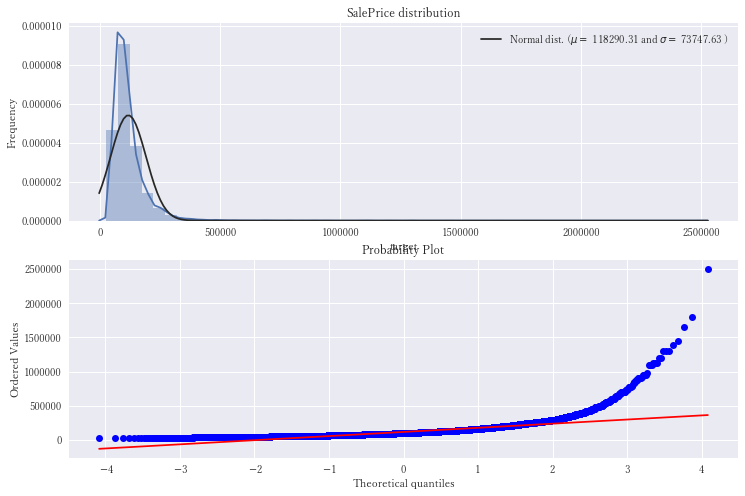

In [16]:
plt.figure(figsize=(12,8))
plt.subplot(211)
g = sns.distplot(train['target'],fit=norm)
(mu,sigma) = norm.fit(train['target'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
g.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
g.set_ylabel('Frequency')
g.set_title('SalePrice distribution')

plt.subplot(212)
stats.probplot(train['target'],plot=plt)

### log(賃料)


 mu = 11.56 and sigma = 0.46



((array([-4.08513702, -3.87431282, -3.75917019, ...,  3.75917019,
          3.87431282,  4.08513702]),
  array([10.1266711 , 10.16589028, 10.17355286, ..., 14.32232876,
         14.40329778, 14.73180169])),
 (0.45420385928064166, 11.562303507629348, 0.9892433316118493))

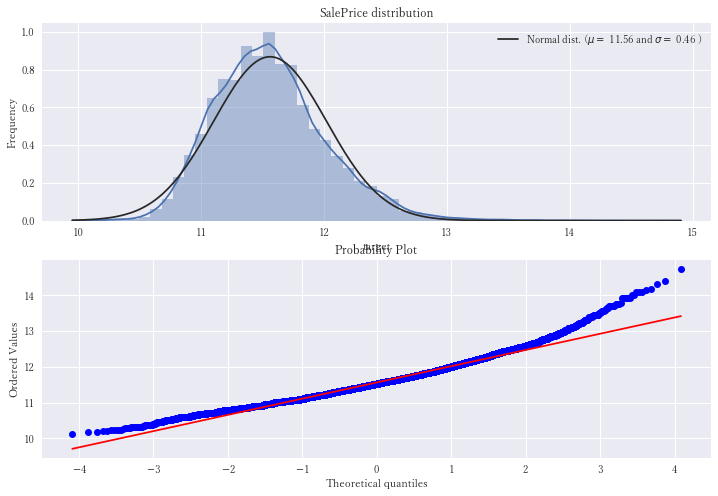

In [17]:
plt.figure(figsize=(12,8))
plt.subplot(211)
g = sns.distplot(np.log1p(train['target']),fit=norm)
(mu,sigma) = norm.fit(np.log1p(train['target']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
g.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
g.set_ylabel('Frequency')
g.set_title('SalePrice distribution')

plt.subplot(212)
stats.probplot(np.log1p(train['target']),plot=plt)

### 所在地

#### 緯度経度取得用CSVを作成

In [18]:
#location = pd.concat([train[['id','location']],test[['id','location']]])
#location = location.drop_duplicates(subset='location')
#len(location)
#location.to_csv('../input/location.csv',index=False,encoding='cp932')

#### 緯度経度追加

In [21]:
loc = pd.read_table('../../input/location.txt',encoding='cp932',delimiter=',')
print(len(loc))
print(loc[' lon'].nunique())
loc.tail()

17199
13318


location        lat         lon
17194    東京都千代田区神田淡路町２丁目  35.697146  139.767444
17195  東京都練馬区石神井台３丁目38-7  35.742963  139.588665
17196    東京都板橋区板橋２丁目17-9  35.747163  139.709823
17197    東京都世田谷区梅丘１丁目６－８  35.653300  139.654156
17198    東京都世田谷区下馬１丁目5-3  35.638697  139.683262

In [22]:
## -の正規化
train['location'] = train['location'].apply(lambda x: x.replace('−','－'))
test['location'] = test['location'].apply(lambda x: x.replace('−','－'))
loc['location'] = loc['location'].apply(lambda x: x.replace('−','－'))

In [23]:
## lon, latのマッピング
lat_map = loc.groupby('location')[' lat'].max()
lon_map = loc.groupby('location')[' lon'].max()
train['loc_lat'] = train.location.map(lat_map)
train['loc_lon'] = train.location.map(lon_map)

test['loc_lat'] = test.location.map(lat_map)
test['loc_lon'] = test.location.map(lon_map)

In [24]:
print(train.isnull().sum())
print(test.isnull().sum())

id             0
target         0
location       0
access         0
floor_plan     0
age            0
direction      0
area           0
Floor          0
Bath_Toilet    0
kitchen        0
broadcast      0
facilities     0
parking        0
env            0
structure      0
year           0
loc_lat        0
loc_lon        0
dtype: int64
id             0
location       0
access         0
floor_plan     0
age            0
direction      0
area           0
Floor          0
Bath_Toilet    0
kitchen        0
broadcast      0
facilities     0
parking        0
env            0
structure      0
year           0
loc_lat        0
loc_lon        0
dtype: int64


In [27]:
sample = train.sample(n=200)

In [28]:
## 賃貸を地図に表示
import folium

map = folium.Map(location=[35.638697, 139.683262], zoom_start=11)
 
for i, r in sample.iterrows():
    folium.CircleMarker(location=[r['loc_lat'], r['loc_lon']],popup=r['target'], 
                        color='crimson',fill=True,radius=r['target']/50000).add_to(map)
    
map

In [51]:
## 緯度経度のサインコサイン変換
from math import sin, cos,radians
train['sin_loc_lat'] = train.loc_lat.apply(lambda x: sin(radians(x)))
train['cos_loc_lon'] = train.loc_lon.apply(lambda x: cos(radians(x)))

test['sin_loc_lat'] = test.loc_lat.apply(lambda x: sin(radians(x)))
test['cos_loc_lon'] = test.loc_lon.apply(lambda x: cos(radians(x)))

In [53]:
train.head()

id  target           location  \
0   1   75000        東京都北区滝野川３丁目   
1   2   76000        東京都中央区月島３丁目   
2   3  110000        東京都渋谷区笹塚２丁目   
3   4  150000  東京都杉並区高円寺南２丁目23-2   
4   5   74000     東京都葛飾区金町３丁目7-2   

                                              access floor_plan      age  \
0  都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...         1K    9年9ヶ月   
1  都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...         1R  44年10ヶ月   
2  京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...         1K    8年6ヶ月   
3  総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...       2LDK   29年4ヶ月   
4  京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...        2DK   31年7ヶ月   

  direction     area     Floor  \
0        南東  20.01m2   1階／12階建   
1         -   16.5m2   5階／10階建   
2         南  22.05m2  12階／15階建   
3         南  60.48m2    3階／4階建   
4         南  39.66m2    1階／2階建   

                                         Bath_Toilet  \
0   専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座   
1                              専用トイレ／\tシャワー／\t温水洗浄便座   
2  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...   
3     専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立   
4               専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能   

                           kitchen                             broadcast  \
0  ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯    インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ   
1          ガスコンロ／\tシステムキッチン\t／\t給湯                             インターネット対応   
2  ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯  インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ   
3                       ガスコンロ／\t給湯                    インターネット対応／\t光ファイバー   
4                      給湯／\t独立キッチン                                     -   

                                          facilities  \
0  エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...   
1  エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...   
2  エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...   
3  エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...   
4                バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水   

                                             parking  \
0                                            駐輪場\t空有   
1                         駐輪場\t空有\t駐車場\t無\tバイク置き場\t無   
2  駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m   
3                          駐車場\t無\t駐輪場\t無\tバイク置き場\t無   
4    駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無   

                                                 env     structure  \
0  【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...  RC（鉄筋コンクリート）   
1                                       【スーパー】 1283m           鉄骨造   
2  【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m  RC（鉄筋コンクリート）   
3  【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...  RC（鉄筋コンクリート）   
4  【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...            木造   

                     year         line station  cost    loc_lat     loc_lon  \
0                     2年間        都営三田線    西巣鴨駅  徒歩4分  35.748456  139.728800   
1                     2年間       都営大江戸線    勝どき駅  徒歩5分  35.662885  139.778627   
2                     2年間          京王線     笹塚駅  徒歩6分  35.675153  139.666255   
3  2年間\t※この物件は\t定期借家\tです。  総武線・中央線（各停）    高円寺駅  徒歩9分  35.700170  139.648465   
4                     2年間        京成金町線   京成金町駅  徒歩5分  35.766431  139.872321   

   sin_loc_lat  cos_loc_lon    center_dis  use_bus    sta_lat     sta_lon  \
0     0.584228    -0.762993   8179.773244        0  35.743694  139.728559   
1     0.583015    -0.763555   3368.632618        0  35.658979  139.777150   
2     0.583189    -0.762287   7132.274400        0  35.673654  139.667136   
3     0.583544    -0.762086   9145.291052        0  35.705346  139.649929   
4     0.584482    -0.764610  15279.706024        0  35.768613  139.870405   

   sin_sta_lat  cos_sta_lon  station_dis  
0    -0.926941     0.072251   528.813124  
1    -0.891868     0.023721   453.545339  
2    -0.898410     0.133339   184.486566  
3    -0.911874     0.150371   589.371881  
4    -0.936002    -0.069476   297.687627

In [24]:
## 距離を求める関数
# 国会議事堂の緯度経度[35.6759323, 139.7450316]
import math
import pyproj
from geopy.distance import great_circle, vincenty

# 赤道半径をWGS84準拠で設定
g = pyproj.Geod(ellps='WGS84')

train['center_dis'] = train.apply(lambda x: vincenty((x['loc_lat'],x['loc_lon']),(35.6759323, 139.7450316)).meters, axis=1)
test['center_dis'] = test.apply(lambda x: vincenty((x['loc_lat'],x['loc_lon']),(35.6759323, 139.7450316)).meters, axis=1)


 mu = 8779.12 and sigma = 3657.66



((array([-4.08513702, -3.87431282, -3.75917019, ...,  3.75917019,
          3.87431282,  4.08513702]),
  array([  626.90924822,   626.90924822,   626.90924822, ...,
         18443.17261989, 18617.78500681, 18617.78500681])),
 (3629.230566717731, 8779.117790822169, 0.9921018885448845))

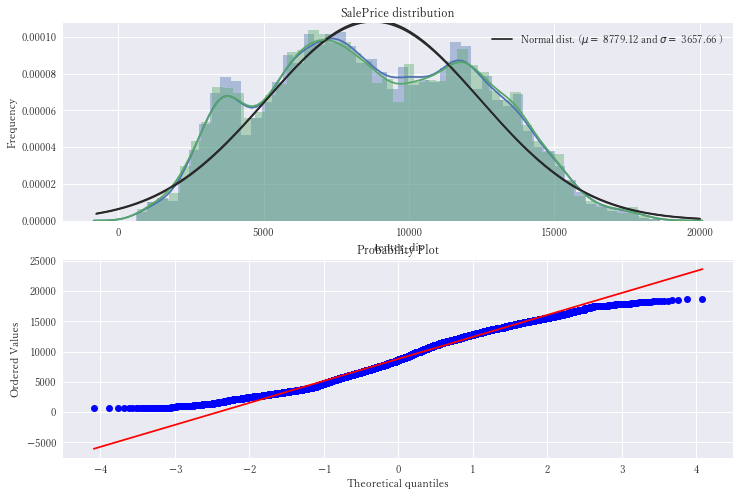

In [25]:
plt.figure(figsize=(12,8))
plt.subplot(211)
g = sns.distplot(train['center_dis'],fit=norm)
g = sns.distplot(test['center_dis'],fit=norm)
(mu,sigma) = norm.fit(train['center_dis'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
g.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
g.set_ylabel('Frequency')
g.set_title('SalePrice distribution')

plt.subplot(212)
stats.probplot(train['center_dis'],plot=plt)

#### 都道府県で分ける

In [224]:
#train['住所1'] = train['location'].apply(lambda x: x.split('都')[0])
#test['住所1'] = test['location'].apply(lambda x: x.split('都')[0])
#print('訓練データ　住所1',train['住所1'].unique())
#print('テストデータ　住所1',test['住所1'].unique())

訓練データも、テストデータも東京都のみ

In [225]:
## 住所1を消す
#train.drop('住所1',axis=1, inplace=True)
#test.drop('住所1',axis=1, inplace=True)

In [226]:
## 東京都という文字を抜く
train['location'] = train['location'].apply(lambda x: x.replace('東京都',''))
test['location'] = test['location'].apply(lambda x: x.replace('東京都',''))

#### 市区町村で分ける

- [東京23区の賃料の相場](https://chintaibest.com/yachin/)

In [227]:
train['location'].head()

0          北区滝野川３丁目
1          中央区月島３丁目
2          渋谷区笹塚２丁目
3    杉並区高円寺南２丁目23-2
4       葛飾区金町３丁目7-2
Name: location, dtype: object

In [228]:
siku = ["千代田区","中央区","港区","新宿区","文京区","台東区","墨田区","江東区","品川区","目黒区","大田区","世田谷区","渋谷区","中野区",
        "杉並区","豊島区","北区","荒川区","板橋区","練馬区","足立区","葛飾区","江戸川区","八王子市","立川市","武蔵野市","三鷹市","青梅市",
        "府中市","昭島市","調布市","町田市","小金井市","小平市","日野市","東村山市","国分寺市","国立市","福生市","狛江市","東大和市",
        "清瀬市","東久留米市","武蔵村山市","多摩市","稲城市","羽村市","あきる野市","西東京市","瑞穂町","日の出町","檜原村","奥多摩町","大島町",
        "利島村","新島村","神津島村","三宅村","御蔵島村","八丈町","青ヶ島村","小笠原村",]

train['city'] = train['location'].apply(lambda x: [s for s in siku if s in x][0])
test['city'] = test['location'].apply(lambda x: [s for s in siku if s in x][0])

In [229]:
print(train['city'].nunique(),train['city'].unique())
print(test['city'].nunique(),test['city'].unique())

23 ['北区' '中央区' '渋谷区' '杉並区' '葛飾区' '荒川区' '練馬区' '目黒区' '文京区' '板橋区' '大田区' '江戸川区'
 '港区' '墨田区' '新宿区' '中野区' '豊島区' '台東区' '足立区' '世田谷区' '江東区' '品川区' '千代田区']
23 ['世田谷区' '目黒区' '豊島区' '杉並区' '新宿区' '港区' '渋谷区' '葛飾区' '足立区' '板橋区' '江東区' '墨田区'
 '台東区' '練馬区' '中央区' '江戸川区' '品川区' '荒川区' '中野区' '文京区' '大田区' '千代田区' '北区']


23区内だけやないかい

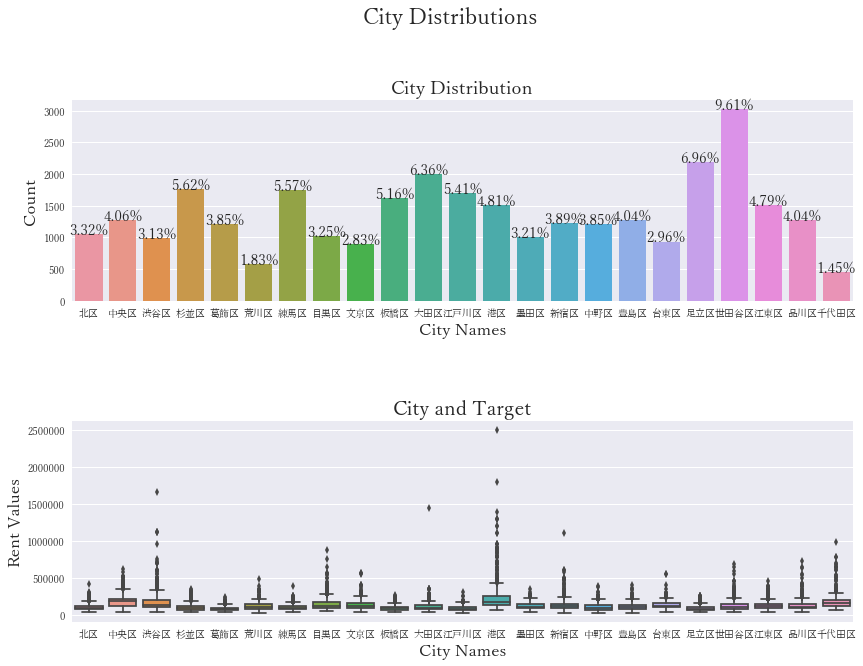

In [230]:
total = len(train)

plt.figure(figsize=(14,10))
plt.suptitle('City Distributions', fontsize=22)

plt.subplot(211)
g = sns.countplot(x='city', data=train,)
g.set_title("City Distribution", fontsize=19)
g.set_xlabel("City Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(212)
g2 = sns.boxplot(x='city', y='target', data=train )
g2.set_title("City and Target", fontsize=20)
g2.set_xlabel("City Names", fontsize=17)
g2.set_ylabel("Rent Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [231]:
train.groupby('city').target.describe().sort_values('mean')

count           mean            std      min       25%       50%  \
city                                                                      
葛飾区   1212.0   79114.657591   26833.282240  29000.0   60000.0   72500.0   
足立区   2191.0   85872.540849   31381.911148  35000.0   63000.0   79000.0   
江戸川区  1702.0   86592.302585   29777.014665  26000.0   65000.0   80000.0   
板橋区   1624.0   90003.879310   32523.361958  28000.0   67000.0   85000.0   
練馬区   1752.0   92724.943493   33092.588718  29000.0   70000.0   87000.0   
杉並区   1769.0   97708.174675   44761.635854  32000.0   65500.0   87000.0   
北区    1045.0   99506.602871   45337.323020  31000.0   70000.0   89000.0   
中野区   1211.0  101578.398018   45599.679076  27000.0   68000.0   92000.0   
大田区   2000.0  106981.675000   52990.714596  28000.0   78000.0   95000.0   
豊島区   1271.0  110916.884343   46429.475471  26200.0   77000.0  100000.0   
世田谷区  3023.0  113781.270261   56556.480094  30000.0   74000.0  103000.0   
墨田区   1010.0  116201.346535   40826.780448  39500.0   89000.0  105000.0   
荒川区    576.0  116817.881944   56384.835547  25000.0   80000.0  100250.0   
品川区   1272.0  124609.473270   65400.524930  30000.0   87000.0  104500.0   
江東区   1508.0  126217.110743   51842.557764  32130.0   94500.0  111000.0   
台東区    932.0  127625.944206   47354.606193  32000.0   99420.0  118000.0   
文京区    892.0  128562.070628   61040.717869  28000.0   89000.0  112000.0   
新宿区   1223.0  130573.957482   75013.499184  27000.0   85000.0  117000.0   
目黒区   1023.0  145674.389052   86626.177042  43000.0   90000.0  121000.0   
渋谷区    985.0  171839.786802  127960.058306  37000.0  102000.0  135000.0   
中央区   1279.0  180887.865520   73472.995282  40000.0  121750.0  178000.0   
千代田区   457.0  182706.236324  114515.251653  68000.0  122000.0  151000.0   
港区    1513.0  214061.744878  162192.418486  55000.0  128000.0  168500.0   

           75%        max  
city                       
葛飾区    93500.0   240000.0  
足立区   101500.0   256000.0  
江戸川区  106000.0   300000.0  
板橋区   105000.0   262000.0  
練馬区   111000.0   388000.0  
杉並区   115000.0   340000.0  
北区    115000.0   420000.0  
中野区   122750.0   385000.0  
大田区   123000.0  1450000.0  
豊島区   132000.0   403000.0  
世田谷区  136000.0   690000.0  
墨田区   142375.0   350000.0  
荒川区   137500.0   486000.0  
品川区   144500.0   720000.0  
江東区   139125.0   450000.0  
台東区   150000.0   550000.0  
文京区   158250.0   558000.0  
新宿区   148500.0  1100000.0  
目黒区   166000.0   880000.0  
渋谷区   198000.0  1660000.0  
中央区   211500.0   620000.0  
千代田区  198000.0   980000.0  
港区    249000.0  2500000.0

#### 街

In [232]:
## 市区町村を抜く
for s in siku:
    train['location'] = train['location'].apply(lambda x: x.replace(s,''))
    test['location'] = test['location'].apply(lambda x: x.replace(s,''))

In [233]:
train['city2'] = train['location'].apply(lambda x: re.split('\d+',x)[0])
test['city2'] = test['location'].apply(lambda x: re.split('\d+',x)[0])

In [234]:
train.groupby(['city']).city2.nunique()

city
世田谷区    60
中央区     33
中野区     19
北区      30
千代田区    36
台東区     32
品川区     24
墨田区     26
大田区     54
文京区     19
新宿区     78
杉並区     36
板橋区     55
江戸川区    44
江東区     42
渋谷区     31
港区      31
目黒区     27
練馬区     43
荒川区      7
葛飾区     28
豊島区     20
足立区     82
Name: city2, dtype: int64

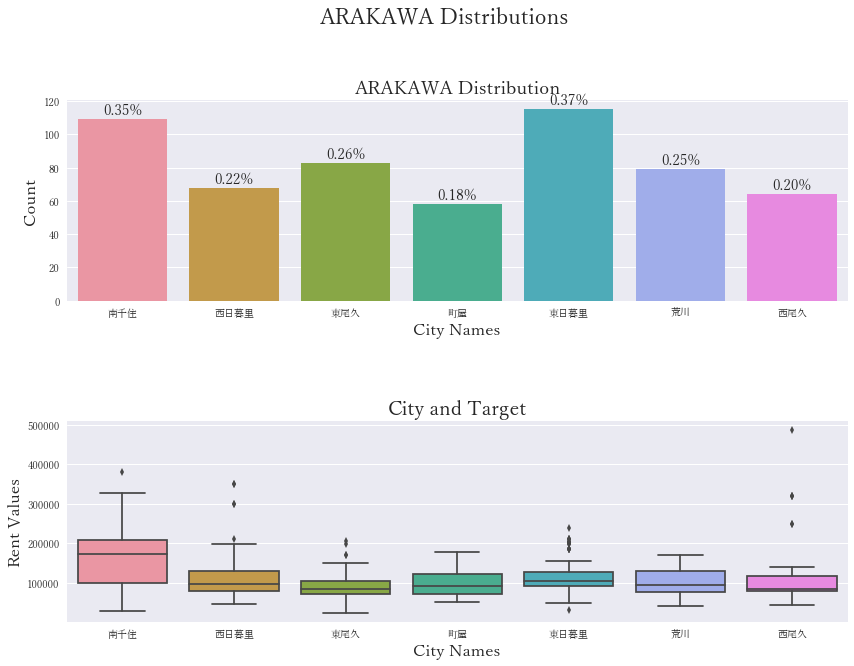

In [235]:
total = len(train)

plt.figure(figsize=(14,10))
plt.suptitle('ARAKAWA Distributions', fontsize=22)

plt.subplot(211)
g = sns.countplot(x='city2', data=train.query('city=="荒川区"'),)
g.set_title("ARAKAWA Distribution", fontsize=19)
g.set_xlabel("City Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(212)
g2 = sns.boxplot(x='city2', y='target', data=train.query('city=="荒川区"'))
g2.set_title("City and Target", fontsize=20)
g2.set_xlabel("City Names", fontsize=17)
g2.set_ylabel("Rent Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

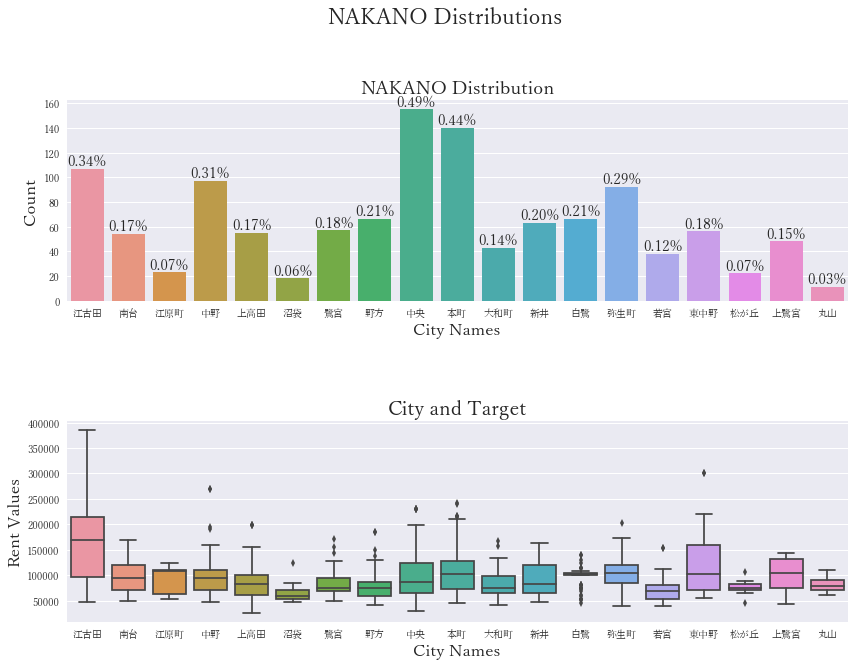

In [236]:
total = len(train)

plt.figure(figsize=(14,10))
plt.suptitle('NAKANO Distributions', fontsize=22)

plt.subplot(211)
g = sns.countplot(x='city2', data=train.query('city=="中野区"'),)
g.set_title("NAKANO Distribution", fontsize=19)
g.set_xlabel("City Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(212)
g2 = sns.boxplot(x='city2', y='target', data=train.query('city=="中野区"'))
g2.set_title("City and Target", fontsize=20)
g2.set_xlabel("City Names", fontsize=17)
g2.set_ylabel("Rent Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

### 間取り

In [237]:
train.floor_plan.unique()

array(['1K', '1R', '2LDK', '2DK', '1DK', '1LDK', '3LDK', '3DK',
       '1LDK+S(納戸)', '4K', '2K', '1K+S(納戸)', '4LDK', '3LDK+S(納戸)',
       '5LDK+S(納戸)', '5LDK', '3K', '4DK', '2LDK+S(納戸)', '2DK+S(納戸)',
       '4LDK+S(納戸)', '5DK', '3DK+S(納戸)', '1DK+S(納戸)', '5K', '6LDK',
       '2K+S(納戸)', '1LK+S(納戸)', '5DK+S(納戸)', '3K+S(納戸)'], dtype=object)

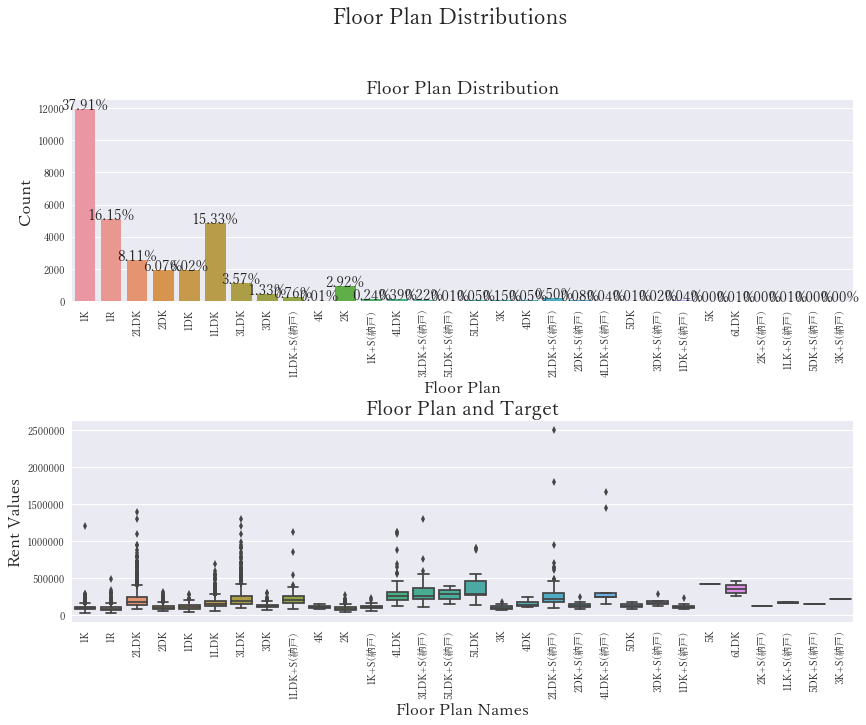

In [238]:
total = len(train)
l = train.floor_plan.unique()

plt.figure(figsize=(14,10))
plt.suptitle('Floor Plan Distributions', fontsize=22)

plt.subplot(211)
g = sns.countplot(x='floor_plan', data=train,)
g.set_title("Floor Plan Distribution", fontsize=19)
g.set_xticklabels(l,rotation=90)
g.set_xlabel("Floor Plan", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(212)
g2 = sns.boxplot(x='floor_plan', y='target', data=train)
g2.set_title("Floor Plan and Target", fontsize=20)
g2.set_xticklabels(l,rotation=90)
g2.set_xlabel("Floor Plan Names", fontsize=17)
g2.set_ylabel("Rent Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [17]:
## 納戸ダミー
train['S'] = train.floor_plan.apply(lambda x: 1 if '納戸' in x else 0)
test['S'] = test.floor_plan.apply(lambda x: 1 if '納戸' in x else 0)

In [18]:
## 納戸を抜いた間取りを別どり
train['floor_plan'] = train.floor_plan.apply(lambda x: x.replace('(納戸)','').replace('+S',''))
test['floor_plan'] = test.floor_plan.apply(lambda x: x.replace('(納戸)','').replace('+S',''))

train['ishitsu'] = train.floor_plan.apply(lambda x:int(re.sub('\\D', '', x)))
test['ishitsu'] = test.floor_plan.apply(lambda x:int(re.sub('\\D', '', x)))

train['L'] = train.floor_plan.apply(lambda x:1 if 'L' in x else 0)
test['L'] = test.floor_plan.apply(lambda x:1 if 'L' in x else 0)

train['D'] = train.floor_plan.apply(lambda x:1 if 'D' in x else 0)
test['D'] = test.floor_plan.apply(lambda x:1 if 'D' in x else 0)

train['K'] = train.floor_plan.apply(lambda x:1 if 'K' in x else 0)
test['K'] = test.floor_plan.apply(lambda x:1 if 'K' in x else 0)

<Figure size 1080x864 with 0 Axes>

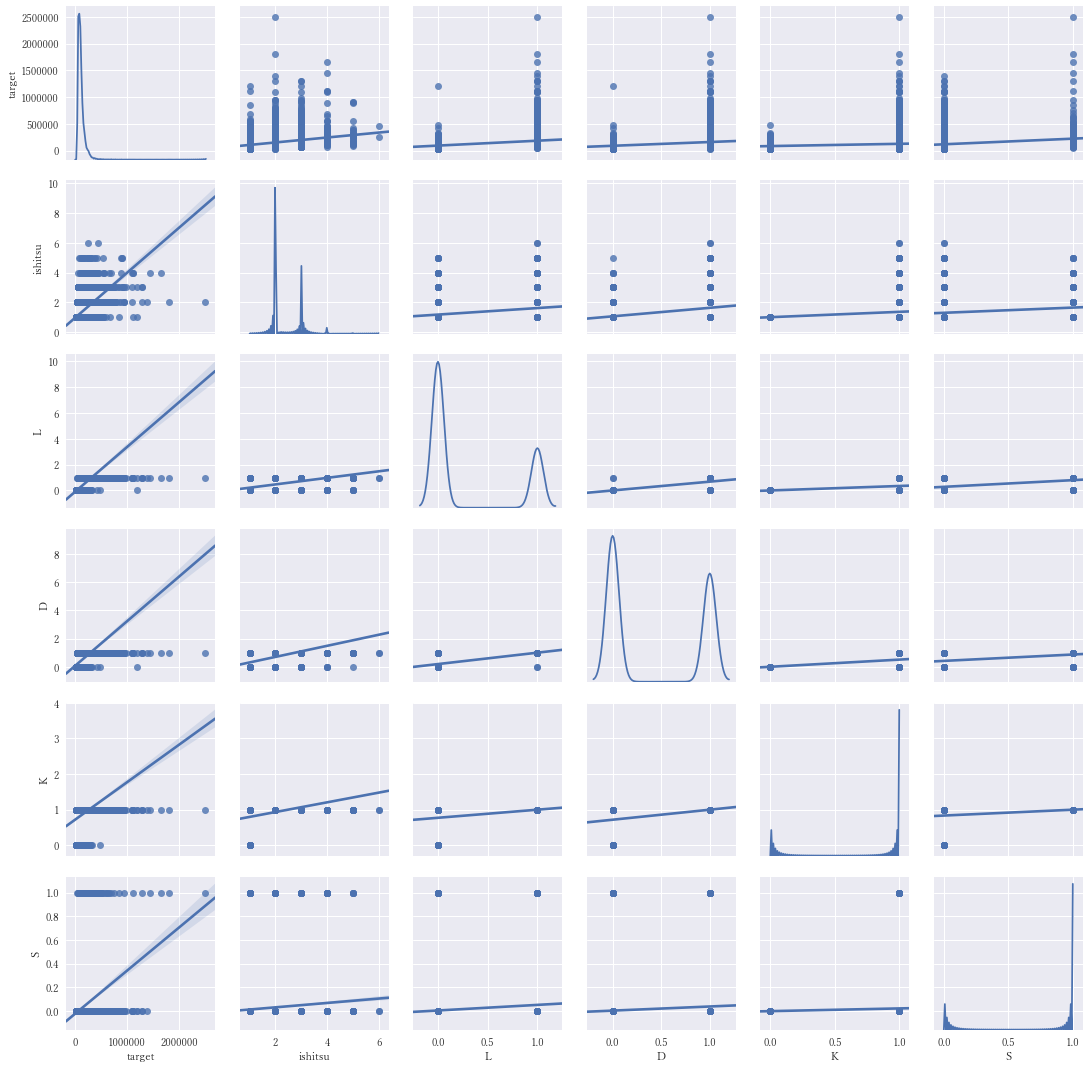

In [19]:
plt.figure(figsize=(15,12))
sns.pairplot(train[['target','ishitsu','L','D','K','S']],kind='reg', diag_kind='kde')

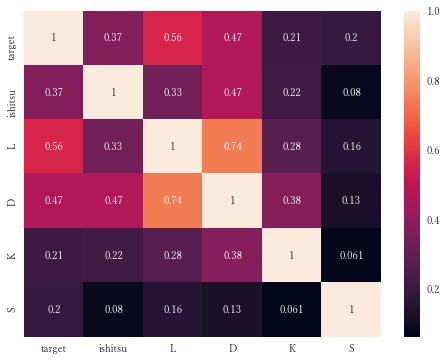

In [20]:
plt.figure(figsize=(8,6))
corr = train[['target','ishitsu','L','D','K','S']].corr()
sns.heatmap(corr,annot=True)

### 築年数

In [242]:
## 新築フラグ
train['new'] = train.age.apply(lambda x:1 if x=='新築' else 0)
test['new'] = test.age.apply(lambda x: 1 if x=='新築' else 0)

## 新築を0年0カ月に
train['age'] = train.age.apply(lambda x:'0年0ヶ月' if x=='新築' else x)
test['age'] = test.age.apply(lambda x: '0年0ヶ月' if x=='新築' else x)

In [243]:
train['age_year'] = train.age.apply(lambda x: int(re.sub('\\D', '', x.split('年')[0])))
test['age_year'] = test.age.apply(lambda x: int(re.sub('\\D', '', x.split('年')[0])))

train['age_month'] = train.age.apply(lambda x: int(re.sub('\\D', '', x.split('年')[1])))
test['age_month'] = test.age.apply(lambda x: int(re.sub('\\D', '', x.split('年')[1])))

train['age'] = train.age.apply(lambda x: int(re.sub('\\D', '', x.split('年')[0]))*12 + int(re.sub('\\D', '', x.split('年')[1])))
test['age'] = test.age.apply(lambda x: int(re.sub('\\D', '', x.split('年')[0]))*12 + int(re.sub('\\D', '', x.split('年')[1])))

In [244]:
## 築年数の外れ値を削除
train = train.query('age<6000')

In [246]:
pd.concat([train.age.describe().reset_index(),test.age.describe().reset_index()],axis=1)

index           age  index           age
0  count  31468.000000  count  31262.000000
1   mean    193.761631   mean    195.390026
2    std    164.802722    std    165.242012
3    min      0.000000    min      0.000000
4    25%     41.000000    25%     43.000000
5    50%    161.000000    50%    161.000000
6    75%    329.000000    75%    330.000000
7    max   1433.000000    max   1336.000000

train : 
 mu = 193.76 and sigma = 164.80

test : 
 mu = 195.39 and sigma = 165.24



Text(0.5,1,'Age distribution')

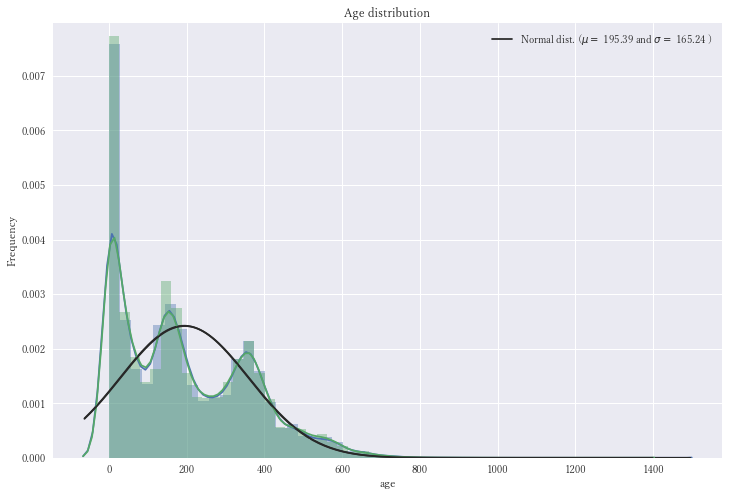

In [247]:
plt.figure(figsize=(12,8))
g = sns.distplot(train['age'],fit=norm, label='train')
g1 = sns.distplot(test['age'],fit=norm, label='test')
(mu_tr,sigma_tr) = norm.fit(train['age'])
(mu_te,sigma_te) = norm.fit(test['age'])
print( 'train : \n mu = {:.2f} and sigma = {:.2f}\n'.format(mu_tr, sigma_tr))
print( 'test : \n mu = {:.2f} and sigma = {:.2f}\n'.format(mu_te, sigma_te))
g.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu_tr, sigma_tr)],loc='best')
g.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu_te, sigma_te)],loc='best')
g.set_ylabel('Frequency')
g.set_title('Age distribution')

<Figure size 864x576 with 0 Axes>

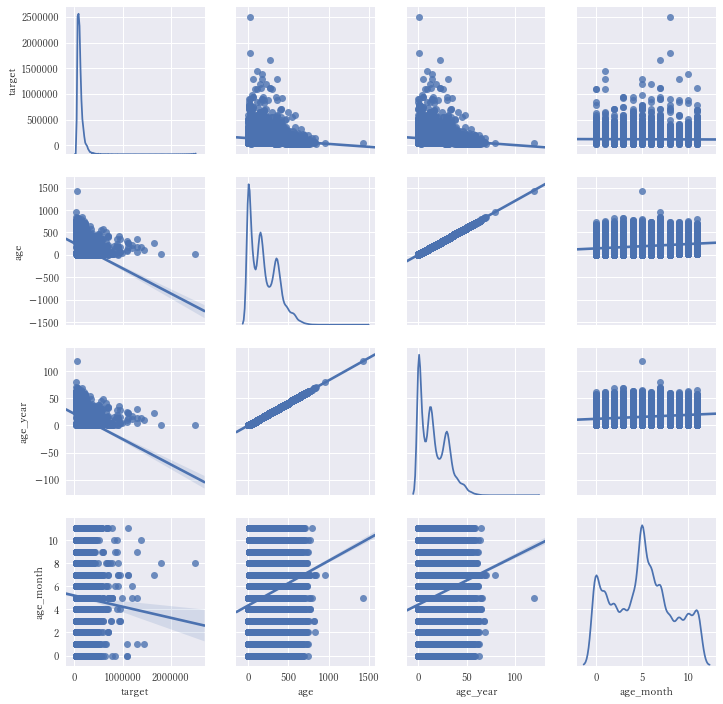

In [248]:
plt.figure(figsize=(12,8))
sns.pairplot(train[['target','age','age_year','age_month']],kind='reg', diag_kind='kde')

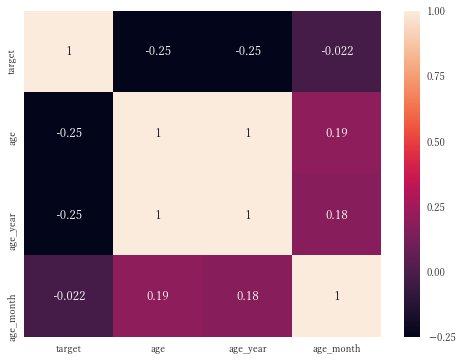

In [249]:
plt.figure(figsize=(8,6))
corr = train[['target','age','age_year','age_month']].corr()
sns.heatmap(corr,annot=True)

### 方角

In [8]:
train['direction'] = train['direction'].fillna('-')
test['direction'] = test['direction'].fillna('-')

In [9]:
train.groupby('direction').size()

direction
-     2749
北     1966
北東    1321
北西    1326
南     8909
南東    3098
南西    3080
東     4995
西     4026
dtype: int64

In [10]:
test.groupby('direction').size()

direction
-     2808
北     1801
北東    1346
北西    1416
南     8788
南東    3052
南西    3042
東     4948
西     4061
dtype: int64

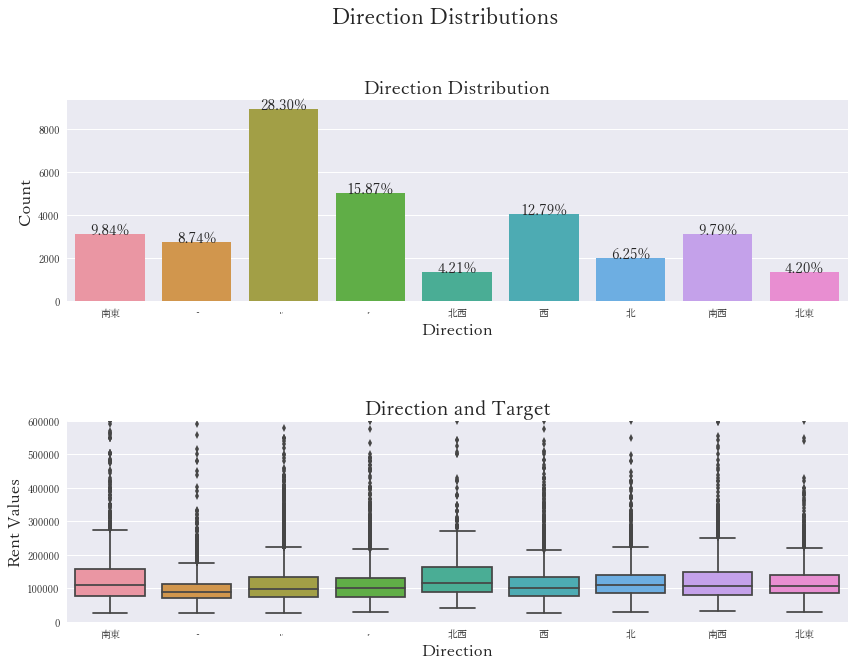

In [252]:
total = len(train)

plt.figure(figsize=(14,10))
plt.suptitle('Direction Distributions', fontsize=22)

plt.subplot(211)
g = sns.countplot(x='direction', data=train,)
g.set_title("Direction Distribution", fontsize=19)
g.set_xlabel("Direction", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(212)
g2 = sns.boxplot(x='direction', y='target', data=train )
g2.set_title("Direction and Target", fontsize=20)
g2.set_xlabel("Direction", fontsize=17)
g2.set_ylabel("Rent Values", fontsize=17)
g2.set_ylim(0,600000)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [253]:
train.groupby('direction').target.describe().sort_values('mean')

count           mean           std      min      25%       50%  \
direction                                                                    
-          2749.0   99139.232448  50074.019176  25000.0  70000.0   88000.0   
東          4995.0  113991.111311  67738.112452  28000.0  75000.0  100000.0   
南          8907.0  114153.569777  70707.661185  27000.0  73000.0   97000.0   
西          4026.0  116873.421510  73947.101425  26000.0  78000.0  102300.0   
北          1966.0  126057.842319  71737.317201  28000.0  85000.0  109000.0   
南西         3080.0  126737.894481  80546.998621  31000.0  81000.0  107250.0   
北東         1321.0  127517.737320  81933.836474  28000.0  87000.0  108000.0   
南東         3098.0  131210.768238  86451.215451  26200.0  78000.0  110000.0   
北西         1326.0  135791.875566  87233.614138  40000.0  89125.0  116250.0   

                75%        max  
direction                       
-          113000.0   700000.0  
東          132000.0  1390000.0  
南          133000.0  1800000.0  
西          133000.0  2500000.0  
北          141000.0  1300000.0  
南西         149250.0  1450000.0  
北東         141000.0  1300000.0  
南東         157000.0  1200000.0  
北西         165000.0  1203500.0

大きな違いはない

### 面積

In [254]:
## m2を削除する
train['area'] = train.area.apply(lambda x: x.rstrip('m2')).replace('','0').astype(float)
test['area'] = test.area.apply(lambda x: x.rstrip('m2')).replace('','0').astype(float)

In [255]:
## 面積を小数点で分ける
train['area_int'] = train.area.astype(int)
test['area_int'] = test.area.astype(int)

train['area_decimal'] = train.area - train.area.astype(int)
test['area_decimal'] = test.area - test.area.astype(int)

In [256]:
pd.concat([train.area.describe().reset_index(),test.area.describe().reset_index()],axis=1)

index          area  index          area
0  count  31468.000000  count  31262.000000
1   mean     34.522617   mean     34.564927
2    std     19.037920    std     19.082468
3    min      0.000000    min      0.000000
4    25%     22.330000    25%     22.110000
5    50%     28.140000    50%     28.235000
6    75%     42.340000    75%     42.500000
7    max    430.100000    max    407.610000

train : 
 mu = 34.52 and sigma = 19.04

test : 
 mu = 34.56 and sigma = 19.08



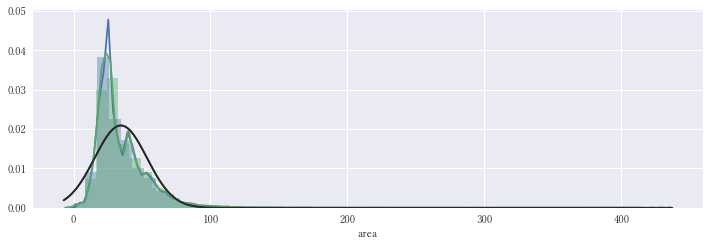

In [257]:
plt.figure(figsize=(12,8))
plt.subplot(211)
(mu_tr,sigma_tr) = norm.fit(train['area'])
(mu_te,sigma_te) = norm.fit(test['area'])
print( 'train : \n mu = {:.2f} and sigma = {:.2f}\n'.format(mu_tr, sigma_tr))
print( 'test : \n mu = {:.2f} and sigma = {:.2f}\n'.format(mu_te, sigma_te))
g = sns.distplot(train['area'],fit=norm)
g = sns.distplot(test['area'],fit=norm)

<Figure size 864x576 with 0 Axes>

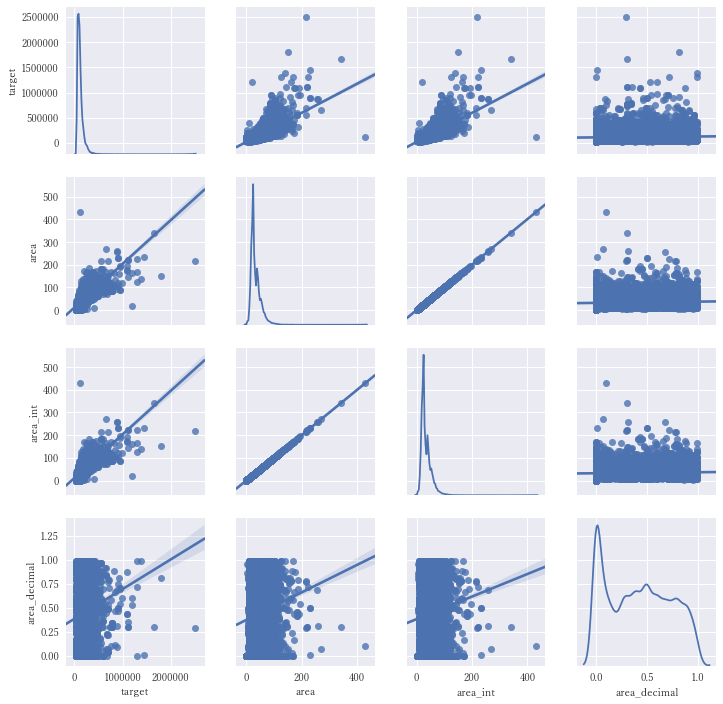

In [258]:
plt.figure(figsize=(12,8))
sns.pairplot(train[['target','area','area_int','area_decimal']],kind='reg', diag_kind='kde')

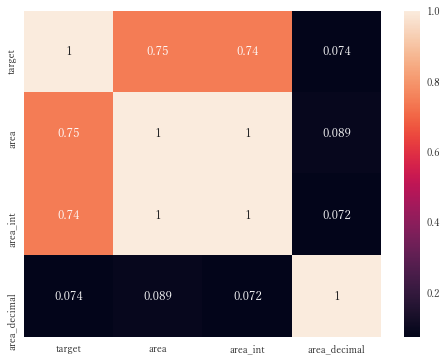

In [259]:
plt.figure(figsize=(8,6))
corr = train[['target','area','area_int','area_decimal']].corr()
sns.heatmap(corr,annot=True)

In [260]:
train.query('area>400')

id  target location  \
20926  20927  116000   南千住７丁目   

                                                  access floor_plan  age  \
20926  日比谷線\t南千住駅\t徒歩7分\t\t京成本線\t千住大橋駅\t徒歩10分\t\t都電荒川...       2LDK  239   

      direction   area    Floor  \
20926         西  430.1  2階／10階建   

                                             Bath_Toilet  \
20926  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立...   

                                   kitchen  \
20926  ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t独立キッチン   

                                         broadcast  \
20926  インターネット対応／\t光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ   

                                              facilities  \
20926  エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...   

                          parking  \
20926  駐輪場\t空有\t駐車場\t無\tバイク置き場\t無   

                                                     env structure year city  \
20926  【スーパー】 432m\t【スーパー】 532m\t【コンビニ】 111m\t【コンビニ】 ...       鉄骨造  NaN  荒川区   

      city2  S  new  age_year  age_month  area_int  area_decimal  
20926   南千住  0    0        19         11       430           0.1

In [261]:
test.query('area>400')

id location                                    access floor_plan  \
7793  39264  田園調布３丁目  東急東横線\t田園調布駅\t徒歩4分\t\t東急目黒線\t田園調布駅\t徒歩4分       6LDK   

      age direction    area      Floor  \
7793  161         南  407.61  2階建（地下1階）   

                                            Bath_Toilet  \
7793  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   

                        kitchen broadcast  \
7793  IHコンロ\t／\tシステムキッチン\t／\t給湯      CATV   

                                             facilities  parking  env  \
7793  エアコン付／\t床暖房\tウォークインクローゼット\tバルコニー／\tフローリング／\t室内...  駐車場\t空有  NaN   

     structure                    year city city2  S  new  age_year  \
7793        木造  5年間\t※この物件は\t定期借家\tです。  大田区  田園調布  1    0        13   

      age_month  area_int  area_decimal  
7793          5       407          0.61

### 所在階

In [262]:
test[test['Floor'].isnull()]

id     location                                             access  \
9204  40675  宇喜田町1469-35  都営新宿線\t船堀駅\t徒歩11分\t\t東西線\t西葛西駅\t徒歩20分\t\t東西線\t...   

     floor_plan  age direction   area Floor  \
9204       3LDK    4        南西  94.91   NaN   

                                            Bath_Toilet              kitchen  \
9204  バス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄便座／\t洗面台...  システムキッチン\t／\tL字キッチン   

     broadcast                   facilities parking  env structure year  city  \
9204       NaN  バルコニー／\tルーフバルコニー\t／\tフローリング     NaN  NaN       鉄骨造  2年間  江戸川区   

     city2  S  new  age_year  age_month  area_int  area_decimal  
9204  宇喜田町  0    0         0          4        94          0.91

In [263]:
## testの欠損値を埋める
test['Floor'] = test['Floor'].fillna('3階')

In [264]:
## 総階数
train['total_Floor'] = train.Floor.apply(lambda x: str(x).split('／')[1] if len(str(x).split('／'))>1 else x)
test['total_Floor'] = test.Floor.apply(lambda x: str(x).split('／')[1] if len(str(x).split('／'))>1 else x)

In [265]:
## 戸建てをダミー変数に、地下階数がある場合は別途記載
train['kodate'] = train.Floor.apply(lambda x: 0 if '／' in str(x) else 1)
test['kodate'] = test.Floor.apply(lambda x: 0 if '／' in str(x) else 1)

train['chika'] = train.Floor.apply(lambda x: int(re.sub('\\D', '', str(x).split('地下')[1].split('階')[0])) if '地下' in str(x) else 0)
test['chika'] = test.Floor.apply(lambda x: int(re.sub('\\D', '', str(x).split('地下')[1].split('階')[0])) if '地下' in str(x) else 0)

In [266]:
## 地上の総階数を数値化
train['total_Floor'] = train.total_Floor.apply(lambda x: str(x).split('階')[0]).astype('int')
test['total_Floor'] = test.total_Floor.apply(lambda x: str(x).split('階')[0]).astype('int')

In [267]:
## 所在階を数値に
train['_Floor'] = train.Floor.apply(lambda x: str(x).split('／')[0] if len(str(x).split('／'))>1 else x)
test['_Floor'] = test.Floor.apply(lambda x: str(x).split('／')[0] if len(str(x).split('／'))>1 else x)

train['_Floor'] = train._Floor.apply(lambda x: '-'+ str(x).split('階')[0].replace('地下','') if '地下' in str(x).split('階')[0] 
                                     else str(x).split('階')[0])
test['_Floor'] = test._Floor.apply(lambda x: '-'+ str(x).split('階')[0].replace('地下','') if '地下' in str(x).split('階')[0] 
                                   else str(x).split('階')[0])

train['_Floor'] = train['_Floor'].replace('',0).astype(int)
test['_Floor'] = test['_Floor'].replace('',0).astype(int)

In [268]:
pd.concat([train._Floor.describe().reset_index(),test._Floor.describe().reset_index()],axis=1)

index        _Floor  index        _Floor
0  count  31468.000000  count  31262.000000
1   mean      3.919220   mean      3.935897
2    std      3.931496    std      3.935850
3    min    -10.000000    min    -15.000000
4    25%      2.000000    25%      2.000000
5    50%      3.000000    50%      3.000000
6    75%      5.000000    75%      5.000000
7    max     53.000000    max     53.000000

train : 
 mu = 3.92 and sigma = 3.93

test : 
 mu = 3.94 and sigma = 3.94



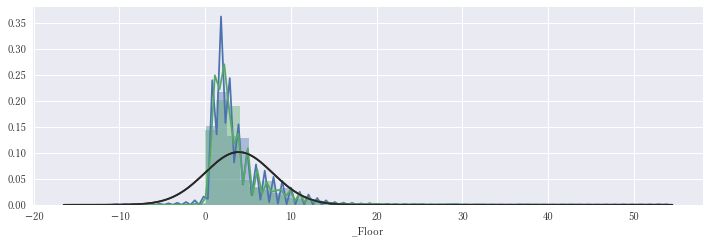

In [269]:
plt.figure(figsize=(12,8))
plt.subplot(211)
(mu_tr,sigma_tr) = norm.fit(train['_Floor'])
(mu_te,sigma_te) = norm.fit(test['_Floor'])
print( 'train : \n mu = {:.2f} and sigma = {:.2f}\n'.format(mu_tr, sigma_tr))
print( 'test : \n mu = {:.2f} and sigma = {:.2f}\n'.format(mu_te, sigma_te))
g = sns.distplot(train['_Floor'],fit=norm)
g = sns.distplot(test['_Floor'],fit=norm)

In [270]:
train['Floor_rate'] = train['_Floor'] / train['total_Floor']
test['Floor_rate'] = test['_Floor'] / test['total_Floor']

<Figure size 864x576 with 0 Axes>

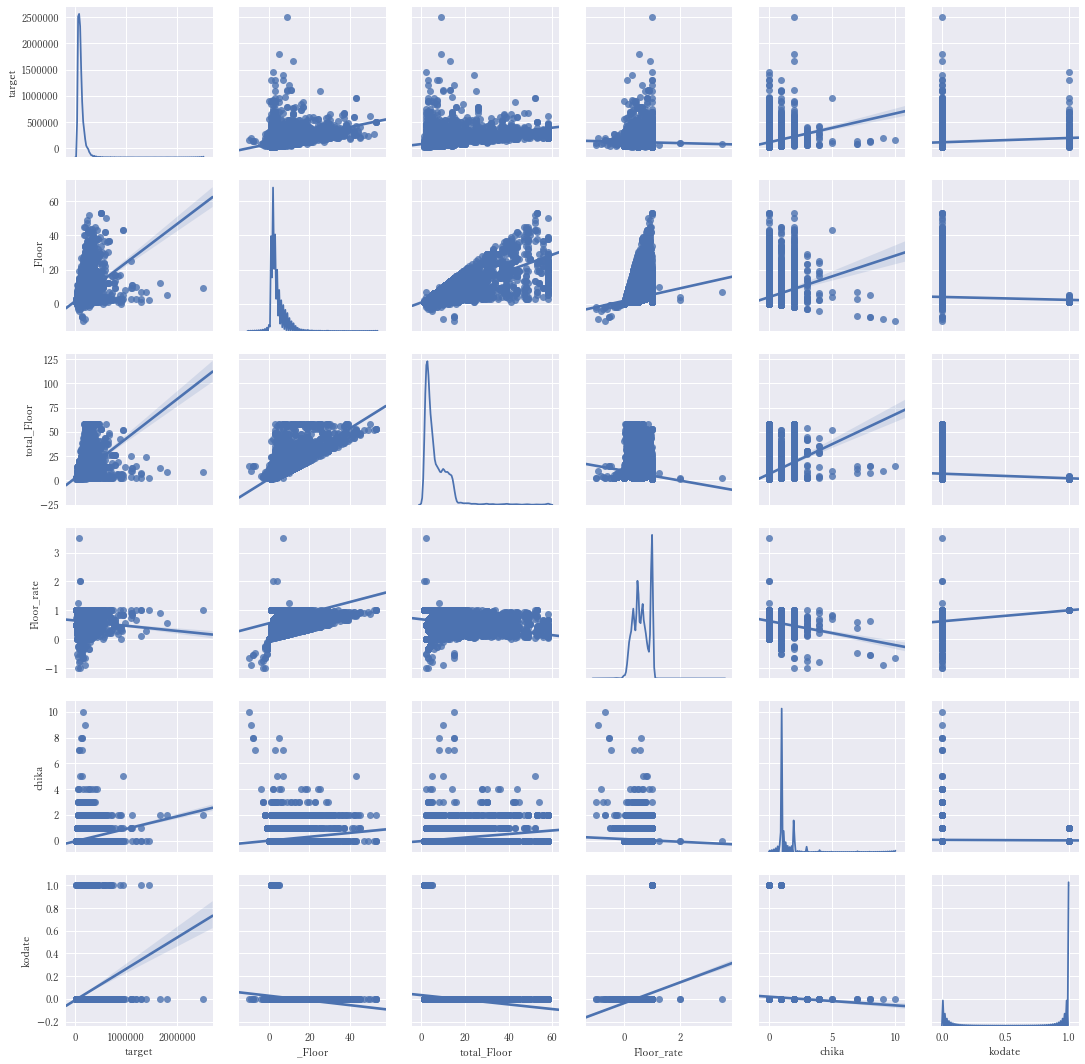

In [271]:
plt.figure(figsize=(12,8))
sns.pairplot(train[['target','_Floor','total_Floor','Floor_rate','chika','kodate']],kind='reg', diag_kind='kde')

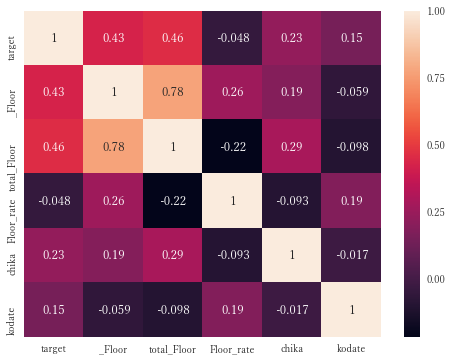

In [272]:
plt.figure(figsize=(8,6))
corr = train[['target','_Floor','total_Floor','Floor_rate','chika','kodate']].corr()
sns.heatmap(corr,annot=True)

In [273]:
train.query('Floor_rate>1').head()

id  target    location  \
1203    1204  110000  小日向１丁目22-2   
14238  14239   62000    海岸３丁目2-9   
20743  20744   89000     高円寺南４丁目   
21504  21505  103000   春日町１丁目9-8   

                                                  access floor_plan  age  \
1203   丸ノ内線(池袋－荻窪)\t茗荷谷駅\t徒歩6分\t\t有楽町線\t江戸川橋駅\t徒歩9分\t...         1R   24   
14238  山手線\t田町(東京都)駅\t徒歩10分\t\t都営三田線\t三田(東京都)駅\t徒歩15分...         1R  532   
20743  総武線・中央線（各停）\t高円寺駅\t徒歩3分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...         1K  204   
21504  都営大江戸線\t練馬春日町駅\t徒歩8分\t\t西武豊島線\t豊島園(西武線)駅\t徒歩13...       2LDK  386   

      direction   area    Floor                        Bath_Toilet  \
1203          -  26.03   2階／1階建                     バス・トイレ別／\tシャワー   
14238        南東  13.77  10階／8階建                専用バス／\t専用トイレ／\tシャワー   
20743        南東  19.13   7階／2階建             バス・トイレ別／\tシャワー／\t浴室乾燥機   
21504         南  43.30   4階／2階建  専用バス／\t専用トイレ／\tシャワー／\t洗面台独立／\t脱衣所   

                               kitchen                             broadcast  \
1203                     電気コンロ／\tコンロ2口                                   NaN   
14238                               給湯                                   NaN   
20743  ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯  インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ   
21504  ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯                      インターネット対応／\tCATV   

                                              facilities  \
1203                                       エアコン付\tフローリング   
14238     エアコン付\tフローリング／\t敷地内ごみ置き場\t／\tエレベーター\t公営水道／\t下水   
20743  エアコン付\tシューズボックス／\t出窓／\tバルコニー／\tフローリング／\t2面採光／\...   
21504  エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\tエ...   

                                                parking  \
1203                                        駐輪場\t空有\t0円   
14238                                 駐輪場\t無\tバイク置き場\t無   
20743                           駐輪場\t空有\t1,000円\t駐車場\t無   
21504  駐輪場\t空有\t駐車場\t近隣\t25,000円(税込)\t距離250m\tバイク置き場\t無   

                                                     env        structure  \
1203                                                 NaN               木造   
14238  【ドラッグストア】 532m\t【飲食店】 242m\t【飲食店】 304m\t【スーパー】...  SRC（鉄骨鉄筋コンクリート）   
20743  【スーパー】 280m\t【コンビニ】 277m\t【ドラッグストア】 5142m\t【病院...     RC（鉄筋コンクリート）   
21504  【スーパー】 245m\t【スーパー】 476m\t【スーパー】 793m\t【コンビニ】 ...     RC（鉄筋コンクリート）   

      year city city2  S  new  age_year  age_month  area_int  area_decimal  \
1203   2年間  文京区   小日向  0    0         2          0        26          0.03   
14238  2年間   港区    海岸  0    0        44          4        13          0.77   
20743  2年間  杉並区  高円寺南  0    0        17          0        19          0.13   
21504  2年間  練馬区   春日町  0    0        32          2        43          0.30   

       total_Floor  kodate  chika  _Floor  Floor_rate  
1203             1       0      0       2        2.00  
14238            8       0      0      10        1.25  
20743            2       0      0       7        3.50  
21504            2       0      0       4        2.00

In [274]:
test.query('Floor_rate>1').head()

id        location  \
956   32427           大井３丁目   
983   32454          西荻北４丁目   
3154  34625  千駄ヶ谷３丁目3-41-12   
5794  37265     篠崎町２丁目１１番８号   
5931  37402     南花畑２丁目２９－１０   

                                                 access floor_plan  age  \
956   横須賀線\t西大井駅\t徒歩8分\t\t東急大井町線\t下神明駅\t徒歩11分\t\t京浜東...         1R  343   
983   中央線（快速）\t西荻窪駅\t徒歩6分\t\t総武線・中央線（各停）\t西荻窪駅\t徒歩6分...         1R  344   
3154  副都心線\t北参道駅\t徒歩1分\t\t総武線・中央線（各停）\t千駄ケ谷駅\t徒歩7分\t...        1DK  241   
5794                                   都営新宿線\t篠崎駅\t徒歩3分         1K  314   
5931  つくばエクスプレス\t六町駅\t徒歩9分\t\t千代田線\t北綾瀬駅\t徒歩31分\t\t東...        2DK  372   

     direction   area          Floor  \
956         南西  18.00         3階／2階建   
983          -  17.00         2階／1階建   
3154         -  26.46  13階／4階建（地下1階）   
5794        北西  25.29         4階／2階建   
5931         東  44.50         3階／2階建   

                                      Bath_Toilet               kitchen  \
956                                       バス・トイレ別  電気コンロ／\tコンロ設置可（口数不明）   
983                           専用バス／\t専用トイレ／\tシャワー    ガスコンロ／\tコンロ2口／\t給湯   
3154                       バス・トイレ別／\tシャワー／\t洗面台独立           給湯／\t独立キッチン   
5794                                         シャワー            電気コンロ／\t給湯   
5931  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t洗面台独立／\t脱衣所    コンロ設置可（コンロ2口）／\t給湯   

                      broadcast  \
956   インターネット対応／\t光ファイバー／\tCATV   
983                         NaN   
3154                        NaN   
5794                  インターネット対応   
5931                       CATV   

                                             facilities  \
956   エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室外洗濯機置場\t公営...   
983   エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t2面採光／\t室外洗濯...   
3154                            冷房／\tエアコン付\t2面採光／\t3面採光   
5794  エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t2面採光／\t室内洗濯...   
5931       シューズボックス／\tバルコニー／\t室内洗濯機置場\t公営水道／\t下水／\t都市ガス   

                        parking  \
956             駐輪場\t空有\t駐車場\t無   
983   駐車場\t無\t駐輪場\t無\tバイク置き場\t無   
3154                駐輪場\t空有\t0円   
5794          駐車場\t無\tバイク置き場\t無   
5931            駐輪場\t空有\t駐車場\t無   

                                                    env structure year  city  \
956            【スーパー】 420m\t【コンビニ】 375m\t【ドラッグストア】 428m       鉄骨造  2年間   品川区   
983   【スーパー】 554m\t【スーパー】 786m\t【コンビニ】 65m\t【コンビニ】 4...        木造  2年間   杉並区   
3154  【飲食店】 112m\t【飲食店】 169m\t【飲食店】 191m\t【スーパー】 125...       鉄骨造  2年間   渋谷区   
5794  【スーパー】 166m\t【スーパー】 252m\t【飲食店】 111m\t【飲食店】 11...       鉄骨造  2年間  江戸川区   
5931  【ドラッグストア】 316m\t【スーパー】 226m\t【スーパー】 293m\t【コンビ...       鉄骨造  2年間   足立区   

     city2  S  new  age_year  age_month  area_int  area_decimal  total_Floor  \
956     大井  0    0        28          7        18          0.00            2   
983    西荻北  0    0        28          8        17          0.00            1   
3154  千駄ヶ谷  0    0        20          1        26          0.46            4   
5794   篠崎町  0    0        26          2        25          0.29            2   
5931   南花畑  0    0        31          0        44          0.50            2   

      kodate  chika  _Floor  Floor_rate  
956        0      0       3        1.50  
983        0      0       2        2.00  
3154       0      1      13        3.25  
5794       0      0       4        2.00  
5931       0      0       3        1.50

4階／2階建とかわけわからんものも混じっている

階数が高くなればなるほど高くなる

### 建物構造

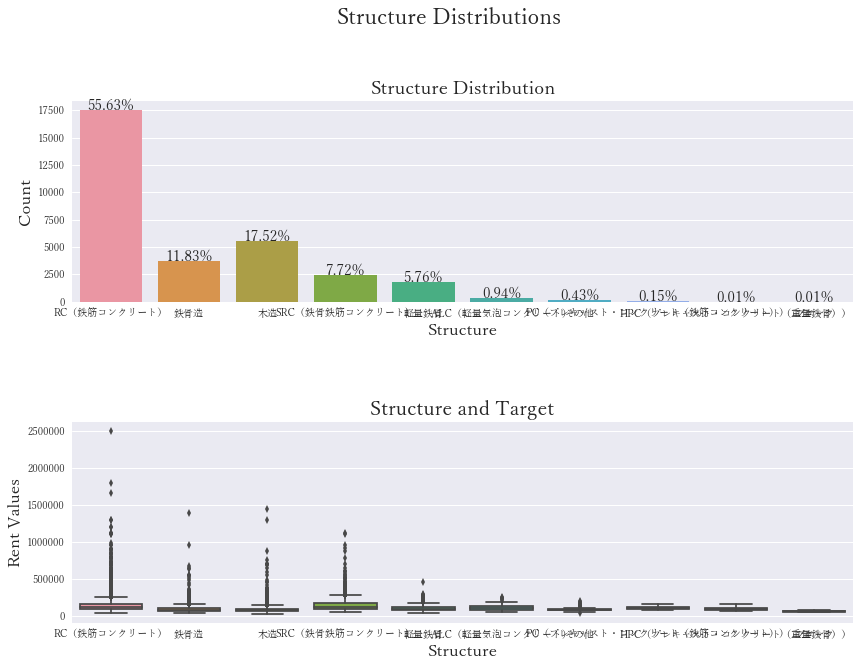

In [275]:
total = len(train)

plt.figure(figsize=(14,10))
plt.suptitle('Structure Distributions', fontsize=22)

plt.subplot(211)
g = sns.countplot(x='structure', data=train,)
g.set_title("Structure Distribution", fontsize=19)
g.set_xlabel("Structure", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(212)
g2 = sns.boxplot(x='structure', y='target', data=train )
g2.set_title("Structure and Target", fontsize=20)
g2.set_xlabel("Structure", fontsize=17)
g2.set_ylabel("Rent Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [276]:
train.groupby('structure').target.describe().sort_values('mean')

count           mean           std      min  \
structure                                                                    
ブロック                             3.0   60000.000000  15000.000000  45000.0   
その他                            136.0   81724.448529  22799.471945  36000.0   
木造                            5512.0   83823.202286  56896.651521  25000.0   
鉄骨造                           3724.0   91991.282492  51635.101528  35000.0   
HPC（プレキャスト・コンクリート（重量鉄骨））         4.0   93000.000000  41044.691090  55000.0   
軽量鉄骨                          1812.0   94458.160044  34477.836339  40000.0   
PC（プレキャスト・コンクリート（鉄筋コンクリート））     46.0  106195.652174  21821.110640  69000.0   
ALC（軽量気泡コンクリート）                297.0  107103.703704  33898.290135  48000.0   
RC（鉄筋コンクリート）                 17505.0  134366.134704  78147.007990  32000.0   
SRC（鉄骨鉄筋コンクリート）               2429.0  142525.408399  85043.488185  42000.0   

                                 25%       50%       75%        max  
structure                                                            
ブロック                         52500.0   60000.0   67500.0    75000.0  
その他                          70000.0   78000.0   85625.0   200000.0  
木造                           57000.0   69000.0   90000.0  1450000.0  
鉄骨造                          67000.0   80000.0  102000.0  1390000.0  
HPC（プレキャスト・コンクリート（重量鉄骨））     69250.0   83500.0  107250.0   150000.0  
軽量鉄骨                         70000.0   87000.0  113075.0   450000.0  
PC（プレキャスト・コンクリート（鉄筋コンクリート））  89250.0  102500.0  117250.0   159000.0  
ALC（軽量気泡コンクリート）              81000.0  102000.0  127000.0   255000.0  
RC（鉄筋コンクリート）                 92000.0  115000.0  155000.0  2500000.0  
SRC（鉄骨鉄筋コンクリート）              91000.0  120000.0  165000.0  1120000.0

### 契約年数

In [11]:
train['year'] = train['year'].fillna('-')
test['year'] = test['year'].fillna('-')

In [12]:
##　契約の月数を数える
train['year_num'] = train.year.apply(lambda x:x.split()[0])
test['year_num'] = test.year.apply(lambda x:x.split()[0])

train['made'] = train.year.apply(lambda x: 1 if 'まで' in x else 0)
test['made'] = test.year.apply(lambda x: 1 if 'まで' in x else 0)

train['year_num'] = train.year_num.apply(lambda x: 12*int(x.split('年間')[0]) if '年間' in x
                                         else 12*int(x.split('年')[0])+int(re.sub('\\D', '', x.split('年')[1])) if ('月間' in x) and ('年' in x)
                                         else int(re.sub('\\D','',x)) if '月間' in x
                                         else 12*(int(re.sub('\\D', '', x.split('年')[0]))-2019)+(int(re.sub('\\D', '', x.split('年')[1]))-10)  
                                                 if ('まで' in x)and (int(re.sub('\\D', '', x.split('年')[1]))-10>0)
                                         else 12*(int(re.sub('\\D', '', x.split('年')[0]))-2020)+13+(int(re.sub('\\D', '', x.split('年')[1]))-10)
                                                 if  'まで' in x
                                         else x)

test['year_num'] = test.year_num.apply(lambda x: 12*int(x.split('年間')[0]) if '年間' in x
                                         else 12*int(x.split('年')[0])+int(re.sub('\\D', '', x.split('年')[1])) if ('月間' in x) and ('年' in x)
                                         else int(re.sub('\\D','',x)) if '月間' in x
                                         else 12*(int(re.sub('\\D', '', x.split('年')[0]))-2019)+(int(re.sub('\\D', '', x.split('年')[1]))-10)  
                                                 if ('まで' in x)and (int(re.sub('\\D', '', x.split('年')[1]))-10>0)
                                         else 12*(int(re.sub('\\D', '', x.split('年')[0]))-2020)+13+(int(re.sub('\\D', '', x.split('年')[1]))-10)
                                                 if  'まで' in x
                                         else x)

train['year_num'] = train.year_num.apply(lambda x: int(x) if x!='-' else x)
test['year_num'] = test.year_num.apply(lambda x: int(x) if x!='-' else x)


## 借家フラグ
train['fixed_term'] = train.year.apply(lambda x: 1 if '定期借家' in x else 0)
test['fixed_term'] = test.year.apply(lambda x: 1 if '定期借家' in x else 0)

train : 
 mu = 24.55 and sigma = 5.33

test : 
 mu = 24.53 and sigma = 4.66



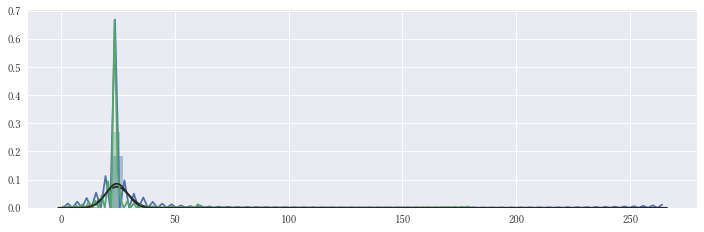

In [13]:
plt.figure(figsize=(12,8))
plt.subplot(211)
(mu_tr,sigma_tr) = norm.fit(train.query('year_num!="-"')['year_num'])
(mu_te,sigma_te) = norm.fit(test.query('year_num!="-"')['year_num'])
print( 'train : \n mu = {:.2f} and sigma = {:.2f}\n'.format(mu_tr, sigma_tr))
print( 'test : \n mu = {:.2f} and sigma = {:.2f}\n'.format(mu_te, sigma_te))
g = sns.distplot(list(train.query('year_num!="-"')['year_num'].values), fit=norm)
g = sns.distplot(list(test.query('year_num!="-"')['year_num'].values),fit=norm)

In [14]:
pd.concat([train.query('year_num!="-"').year_num.describe().reset_index(),test.query('year_num!="-"').year_num.describe().reset_index()],axis=1)

index  year_num   index  year_num
0   count     24350   count     24281
1  unique        49  unique        46
2     top        24     top        24
3    freq     23487    freq     23455

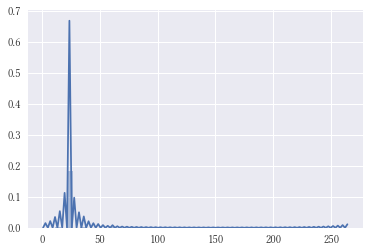

In [15]:
aa = list(train.query('year_num!="-"')['year_num'].values)
sns.distplot(aa)

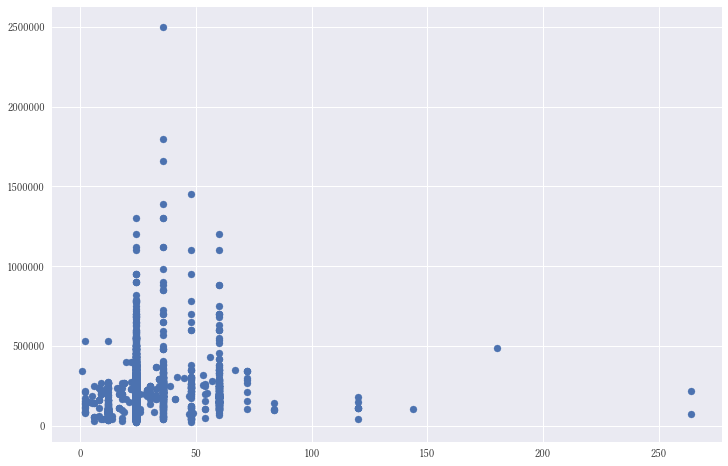

In [16]:
plt.figure(figsize=(12,8))
a = list(train.query('year_num!="-"')['year_num'].values)
b = list(train.query('year_num!="-"')['target'].values)
plt.scatter(a,b)

In [17]:
np.corrcoef(a,b)

array([[1.        , 0.19015173],
       [0.19015173, 1.        ]])

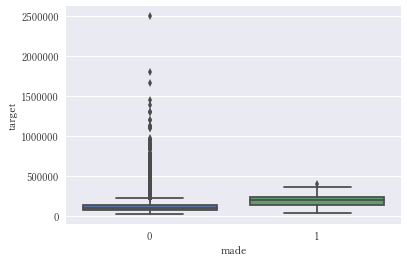

In [18]:
sns.boxplot(x='made',y='target',data=train)

In [380]:
train.groupby('made').target.describe().sort_values('mean')

count           mean           std      min       25%       50%  \
made                                                                      
0     31370.0  118069.076921  73622.476279  25000.0   76000.0  101500.0   
1       100.0  187690.000000  80698.897268  34000.0  133750.0  198000.0   

           75%        max  
made                       
0     136000.0  2500000.0  
1     235000.0   398000.0

契約期間が〇までのやつは比較的高い

### バストイレ

In [23]:
## 何が含まれているのか
b_t = set()
bath = train['Bath_Toilet'].apply(lambda x:str(x).split('／')).values
for lis in bath:
    for i in lis:
        i = i.replace('\t','')
        b_t.add(i)
b_t

{'-',
 'シャワー',
 'バスなし',
 'バス・トイレ別',
 '共同トイレ',
 '共同バス',
 '専用トイレ',
 '専用バス',
 '洗面台独立',
 '浴室乾燥機',
 '温水洗浄便座',
 '脱衣所',
 '追焚機能'}

In [24]:
## それぞれにフラグを立てる
fe = []
for bt in b_t:
    if bt=='-':
        continue
    train[bt] = train.Bath_Toilet.apply(lambda x: 1 if bt in x else 0)
    test[bt] = test.Bath_Toilet.apply(lambda x: 1 if bt in x else 0)
    fe.append(bt)

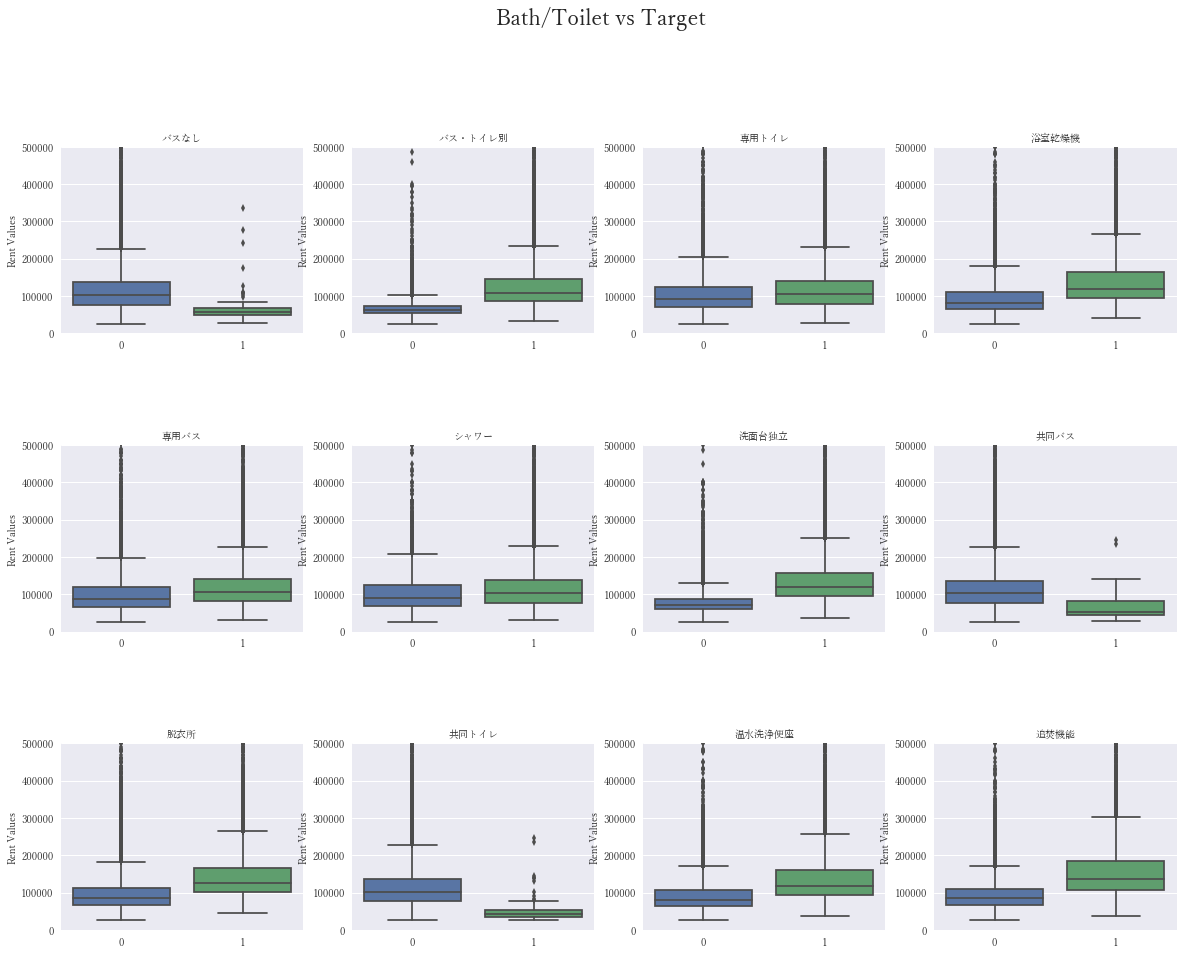

In [38]:
total = len(train)

plt.figure(figsize=(20,15))
plt.suptitle('Bath/Toilet vs Target', fontsize=22)
for i in range(len(fe)):
    plt.subplot(3,4,i+1)
    g = sns.boxplot(x=fe[i], y='target', data=train )
    g.set_title(fe[i], fontsize=10)
    g.set_xlabel("", fontsize=10)
    g.set_ylabel("Rent Values", fontsize=10)
    g.set_ylim(0,500000)
    plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [37]:
for f in fe:
    print(train.groupby(f).target.describe())

        count           mean           std      min      25%       50%  \
バスなし                                                                     
0     31329.0  118533.918829  73781.313735  25000.0  76500.0  102000.0   
1       141.0   64161.702128  37952.123335  27000.0  48000.0   57000.0   

           75%        max  
バスなし                       
0     137000.0  2500000.0  
1      67000.0   334800.0  
           count           mean           std      min      25%       50%  \
バス・トイレ別                                                                     
0         5012.0   71926.759976  61016.271713  25000.0  53375.0   62000.0   
1        26458.0  127073.060020  72661.760111  32000.0  85500.0  109000.0   

              75%        max  
バス・トイレ別                       
0         73000.0  1660000.0  
1        145000.0  2500000.0  
         count           mean           std      min      25%       50%  \
専用トイレ                                                                     
0       

### キッチン

In [5]:
## 何が含まれているのか
kit = set()
kitchen = train['kitchen'].apply(lambda x:str(x).split('／')).values
for lis in kitchen:
    for i in lis:
        i = i.replace('\t','')
        kit.add(i)
kit

{'-',
 'IHコンロ',
 'L字キッチン',
 'カウンターキッチン',
 'ガスコンロ',
 'コンロ1口',
 'コンロ2口',
 'コンロ3口',
 'コンロ4口以上',
 'コンロ設置可（コンロ1口）',
 'コンロ設置可（コンロ2口）',
 'コンロ設置可（コンロ3口）',
 'コンロ設置可（コンロ4口以上）',
 'コンロ設置可（口数不明）',
 'システムキッチン',
 '冷蔵庫あり',
 '独立キッチン',
 '給湯',
 '電気コンロ'}

In [6]:
## それぞれにフラグを立てる
fe = []
for k in kit:
    if k=='-':
        continue
    train[k] = train.kitchen.apply(lambda x: 1 if k in x else 0)
    test[k] = test.kitchen.apply(lambda x: 1 if k in x else 0)
    fe.append(k)

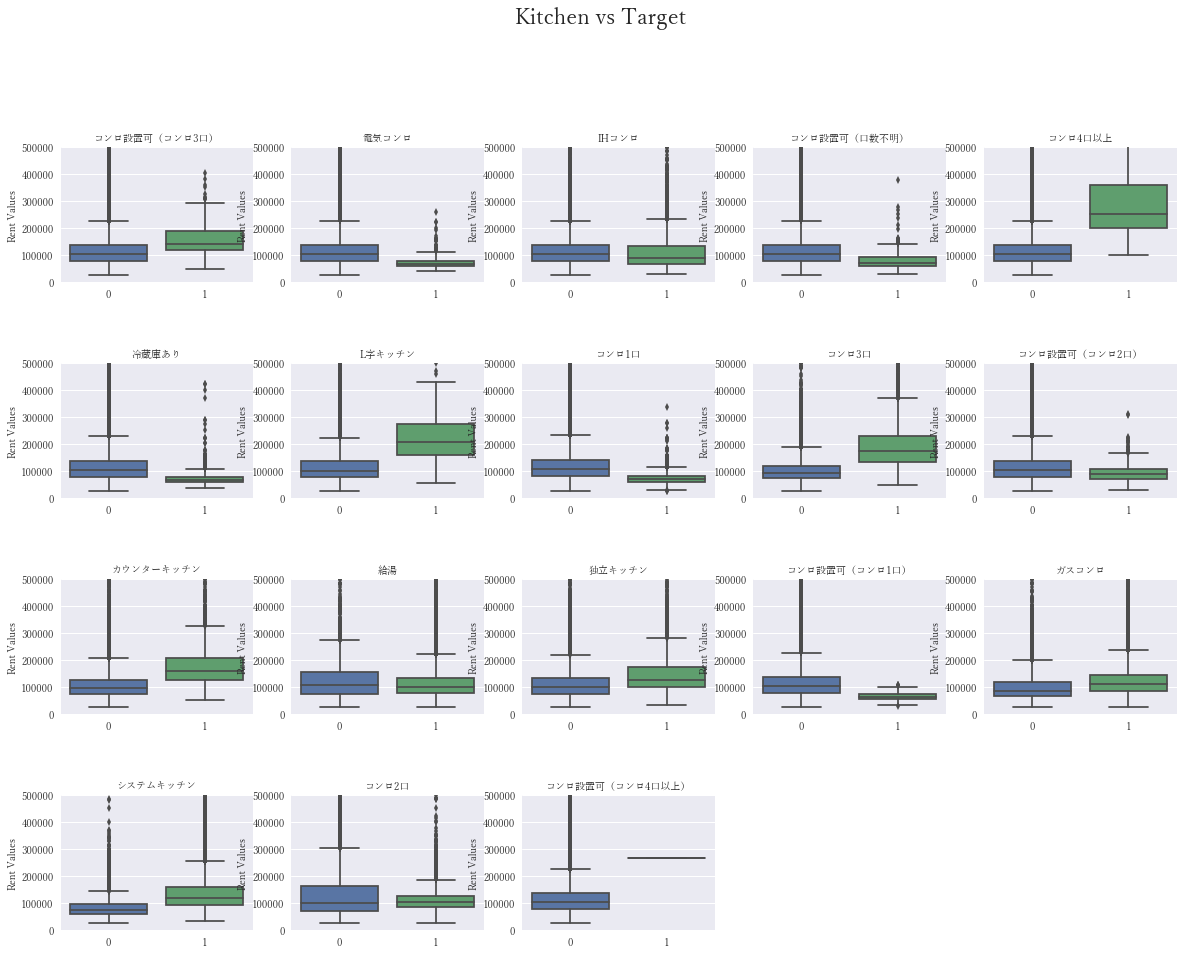

In [7]:
total = len(train)

plt.figure(figsize=(20,15))
plt.suptitle('Kitchen vs Target', fontsize=22)
for i in range(len(fe)):
    plt.subplot(4,5,i+1)
    g = sns.boxplot(x=fe[i], y='target', data=train )
    g.set_title(fe[i], fontsize=10)
    g.set_xlabel("", fontsize=10)
    g.set_ylabel("Rent Values", fontsize=10)
    g.set_ylim(0,500000)
    plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [8]:
for f in fe:
    print(train.groupby(f).target.describe())

                 count           mean           std      min       25%  \
コンロ設置可（コンロ3口）                                                            
0              31316.0  118099.908769  73735.912750  25000.0   76000.0   
1                154.0  157007.792208  65934.050565  47000.0  116000.0   

                    50%       75%        max  
コンロ設置可（コンロ3口）                                 
0              101500.0  136000.0  2500000.0  
1              140000.0  187000.0   402000.0  
         count           mean           std      min      25%       50%  \
電気コンロ                                                                     
0      30945.0  119047.252965  73921.207917  25000.0  77000.0  102000.0   
1        525.0   73673.714286  43789.855069  40000.0  57000.0   67000.0   

            75%        max  
電気コンロ                       
0      137000.0  2500000.0  
1       78500.0   880000.0  
         count           mean           std      min      25%       50%  \
IHコンロ                  

In [9]:
## コンロ数は数値に
train['コンロ'] = train['コンロ1口'] + train['コンロ2口']*2 + train['コンロ3口']*3 + train['コンロ4口以上']*4+train['IHコンロ']+train['ガスコンロ']
test['コンロ'] = test['コンロ1口'] + test['コンロ2口']*2 + test['コンロ3口']*3 + test['コンロ4口以上']*4+test['IHコンロ']+test['ガスコンロ']

## 工数不明は最頻値の2で埋める
train['コンロ設置可'] = train['コンロ設置可（コンロ1口）'] + train['コンロ設置可（コンロ2口）']*2 + train['コンロ設置可（コンロ3口）']*3 + train['コンロ設置可（コンロ4口以上）']*4 + train['コンロ設置可（口数不明）']*2
test['コンロ設置可'] = test['コンロ設置可（コンロ1口）'] + test['コンロ設置可（コンロ2口）']*2 + test['コンロ設置可（コンロ3口）']*3 + test['コンロ設置可（コンロ4口以上）']*4+test['コンロ設置可（口数不明）']*2

train['コンロ計'] = train['コンロ'] + train['コンロ設置可']
test['コンロ計'] = test['コンロ'] + test['コンロ設置可']

<Figure size 864x576 with 0 Axes>

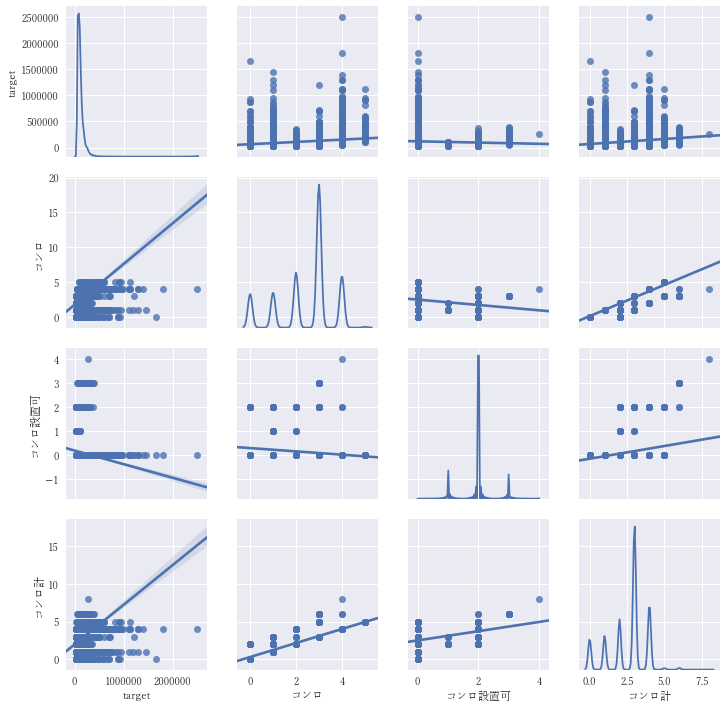

In [11]:
plt.figure(figsize=(12,8))
sns.pairplot(train[['target','コンロ','コンロ設置可','コンロ計']],kind='reg', diag_kind='kde')

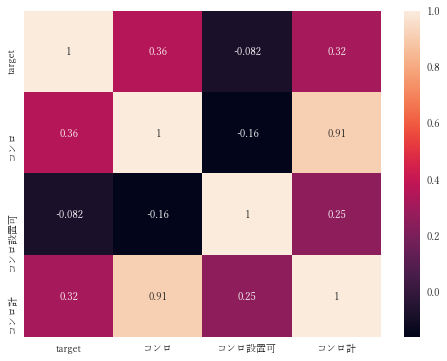

In [12]:
plt.figure(figsize=(8,6))
corr = train[['target','コンロ','コンロ設置可','コンロ計']].corr()
sns.heatmap(corr,annot=True)

### 放送・通信

In [49]:
## 何が含まれているのか
bro = set()
broad = train['broadcast'].apply(lambda x:str(x).split('／')).values
for lis in broad:
    for i in lis:
        i = i.replace('\t','')
        bro.add(i)
bro

{'-',
 'BSアンテナ',
 'CATV',
 'CSアンテナ',
 'インターネット使用料無料',
 'インターネット対応',
 '光ファイバー',
 '有線放送',
 '高速インターネット'}

In [50]:
## それぞれにフラグを立てる
fe = []
for br in bro:
    if br=='-':
        continue
    train[br] = train.broadcast.apply(lambda x: 1 if br in x else 0)
    test[br] = test.broadcast.apply(lambda x: 1 if br in x else 0)
    fe.append(br)

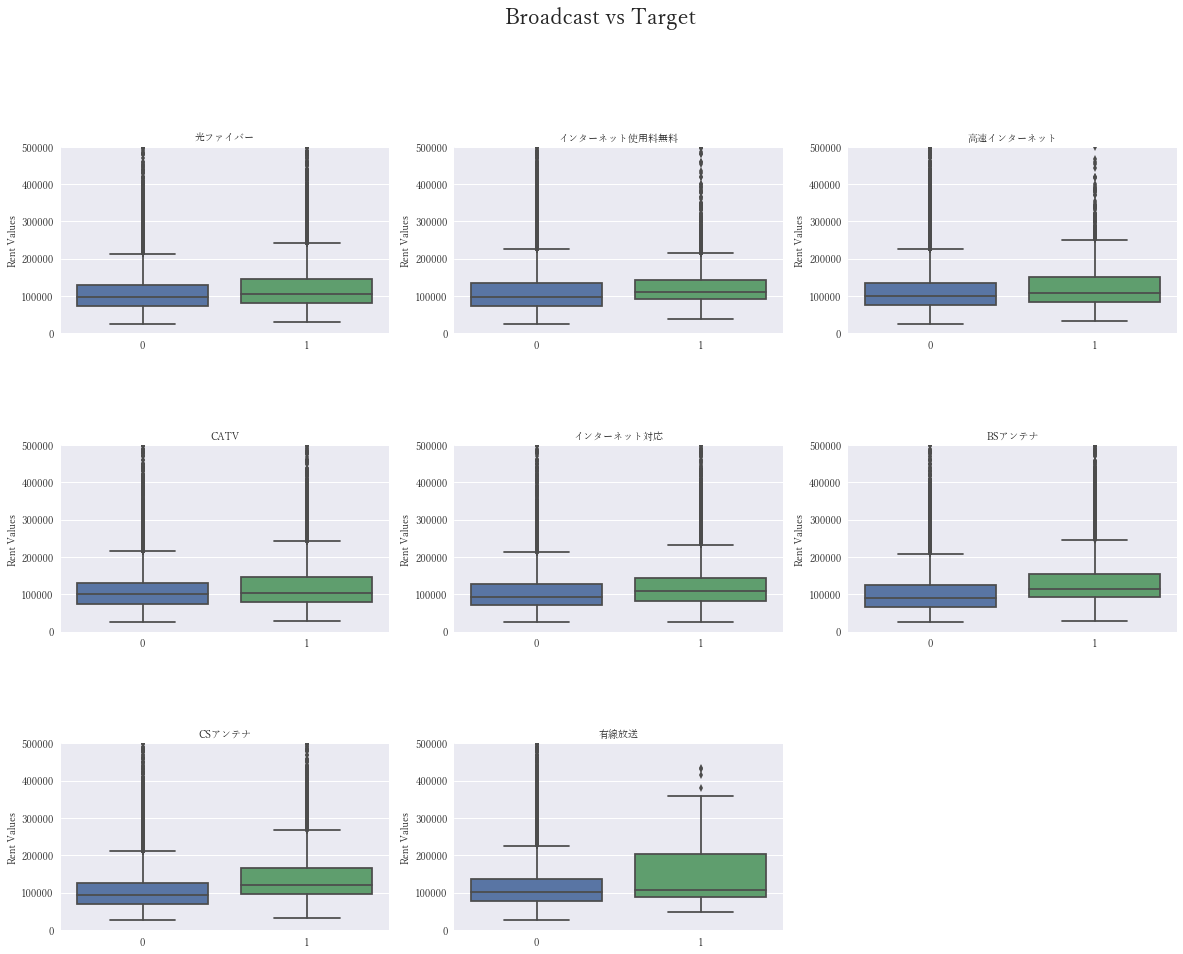

In [53]:
total = len(train)

plt.figure(figsize=(20,15))
plt.suptitle('Broadcast vs Target', fontsize=22)
for i in range(len(fe)):
    plt.subplot(3,3,i+1)
    g = sns.boxplot(x=fe[i], y='target', data=train )
    g.set_title(fe[i], fontsize=10)
    g.set_xlabel("", fontsize=10)
    g.set_ylabel("Rent Values", fontsize=10)
    g.set_ylim(0,500000)
    plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [54]:
for f in fe:
    print(train.groupby(f).target.describe())

          count           mean           std      min      25%       50%  \
光ファイバー                                                                     
0       15164.0  111618.789567  69461.075326  25000.0  73000.0   98000.0   
1       16306.0  124494.579787  77008.877428  29000.0  80000.0  105000.0   

             75%        max  
光ファイバー                       
0       129000.0  2500000.0  
1       145000.0  1450000.0  
                count           mean           std      min      25%  \
インターネット使用料無料                                                           
0             26066.0  116963.792795  77031.187550  25000.0  74000.0   
1              5404.0  124688.697261  54798.613142  37000.0  93000.0   

                   50%       75%        max  
インターネット使用料無料                                 
0              98000.0  135000.0  2500000.0  
1             111000.0  142000.0  1203500.0  
             count           mean           std      min      25%       50%  \
高速インターネット              

### 周辺環境

In [55]:
## 何が含まれているのか
en = set()
env = train['env'].apply(lambda x:str(x).split('\t')).values
for lis in env:
    for i in lis:
        if i =='-':
            continue
        i = re.findall('【.*】',i)[0]
        en.add(i)
en

{'【クリーニング】',
 '【コインパーキング】',
 '【コンビニ】',
 '【スーパー】',
 '【デパート】',
 '【ドラッグストア】',
 '【レンタルビデオ】',
 '【公園】',
 '【図書館】',
 '【大学】',
 '【学校】',
 '【小学校】',
 '【幼稚園・保育園】',
 '【月極駐車場】',
 '【病院】',
 '【総合病院】',
 '【郵便局】',
 '【銀行】',
 '【飲食店】'}

In [56]:
%%time
fe1 = []
fe2 = []
for e in tqdm(en):
    ## 周辺環境との最短距離
    train[str(e)+'_dis'] = train.env.apply(lambda x: int(str(x).split()[str(x).split().index(e)+1].replace('m','')) if e in str(x).split() else 0)
    test[str(e)+'_dis'] = test.env.apply(lambda x: int(str(x).split()[str(x).split().index(e)+1].replace('m','')) if e in str(x).split() else 0)
    fe1.append(str(e)+'_dis')
    
    ## 周辺環境の個数
    train[str(e)+'_num'] = train.env.apply(lambda x: str(x).split().count(e))
    test[str(e)+'_num'] = test.env.apply(lambda x: str(x).split().count(e))
    fe2.append(str(e)+'_num')

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.39it/s]


Wall time: 5.61 s


In [59]:
len(fe1)

19

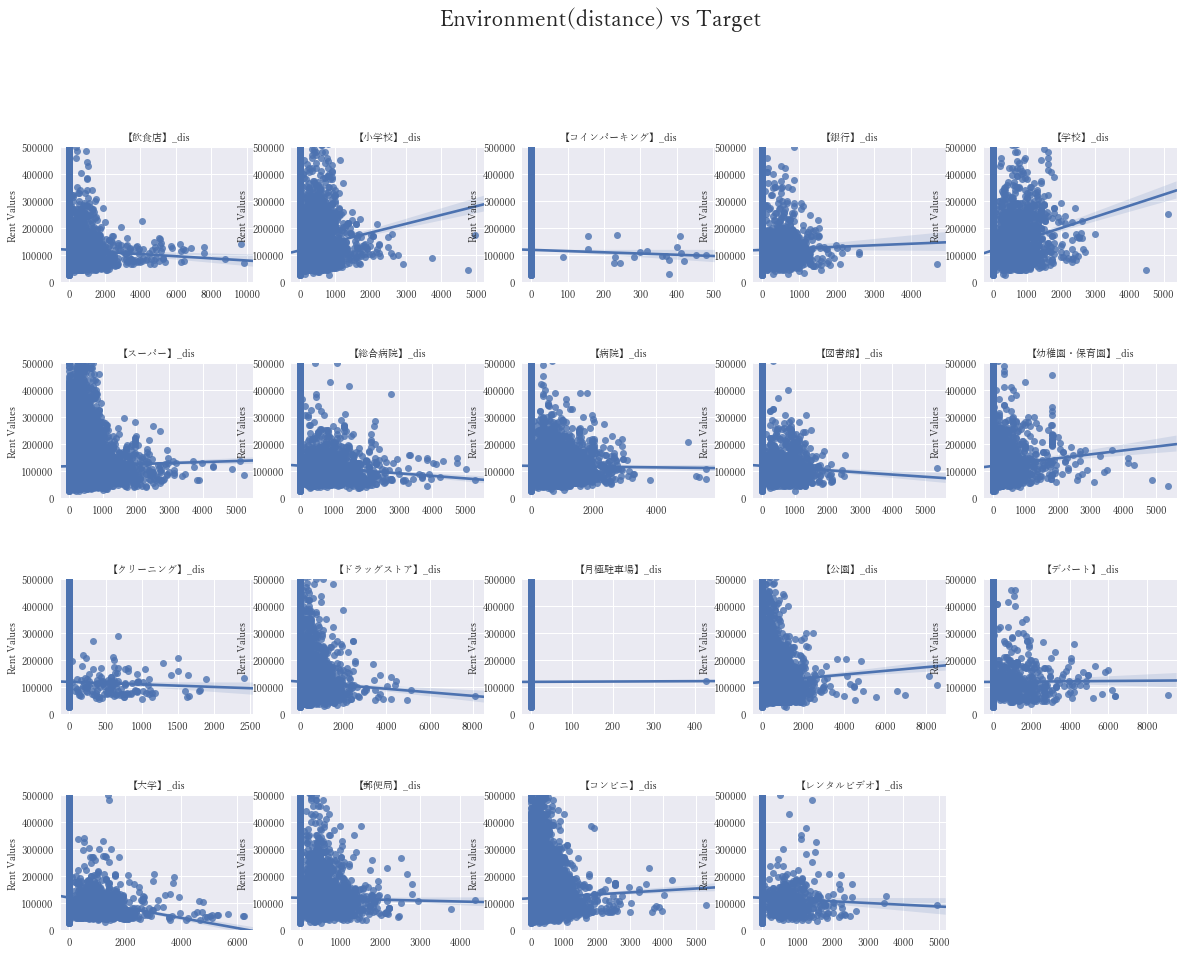

In [61]:
total = len(train)

plt.figure(figsize=(20,15))
plt.suptitle('Environment(distance) vs Target', fontsize=22)
for i in range(len(fe1)):
    plt.subplot(4,5,i+1)
    g = sns.regplot(x=fe1[i], y='target', data=train)
    g.set_title(fe1[i], fontsize=10)
    g.set_xlabel("", fontsize=10)
    g.set_ylabel("Rent Values", fontsize=10)
    g.set_ylim(0,500000)
    plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

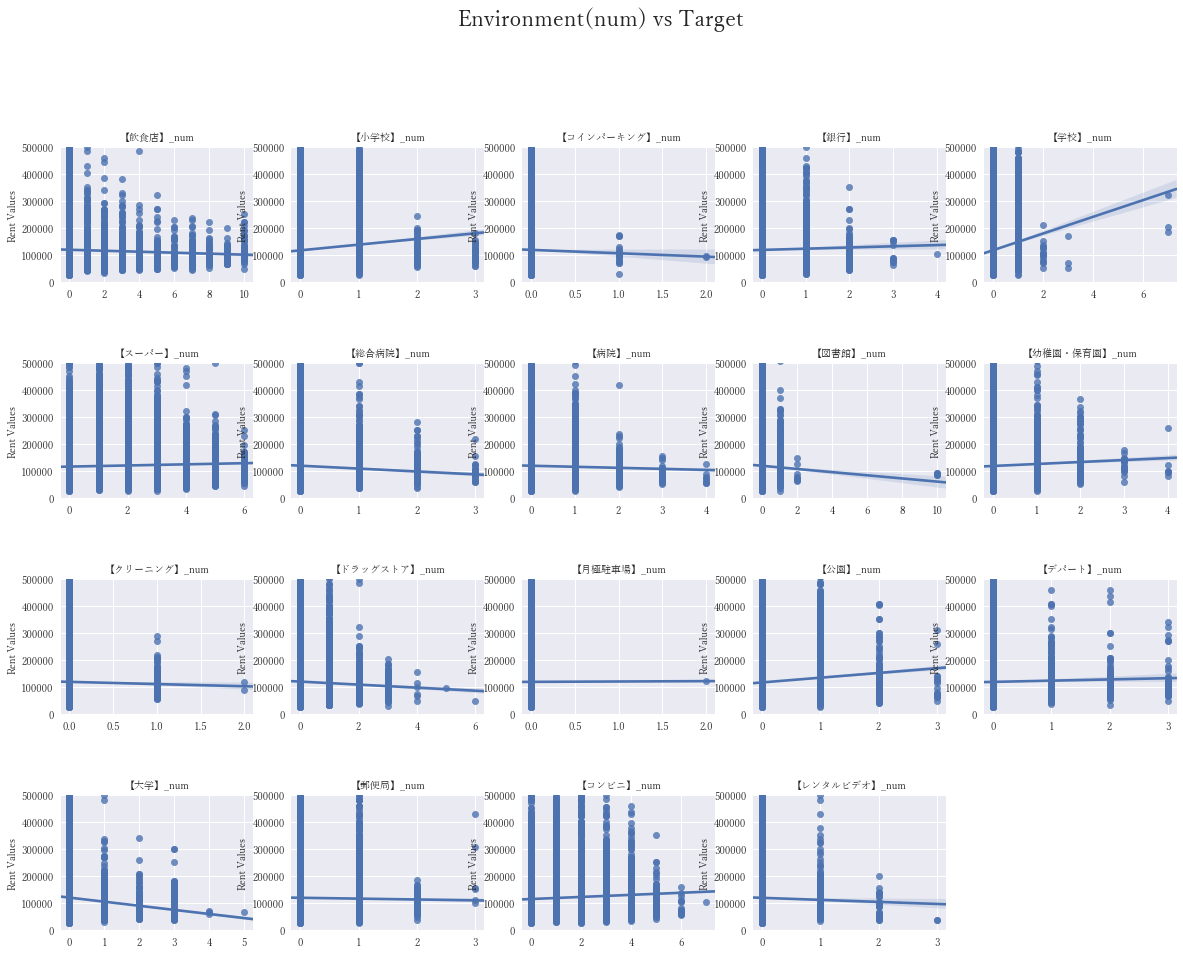

In [62]:
total = len(train)

plt.figure(figsize=(20,15))
plt.suptitle('Environment(num) vs Target', fontsize=22)
for i in range(len(fe2)):
    plt.subplot(4,5,i+1)
    g = sns.regplot(x=fe2[i], y='target', data=train)
    g.set_title(fe2[i], fontsize=10)
    g.set_xlabel("", fontsize=10)
    g.set_ylabel("Rent Values", fontsize=10)
    g.set_ylim(0,500000)
    plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

反比例しているようにみえる

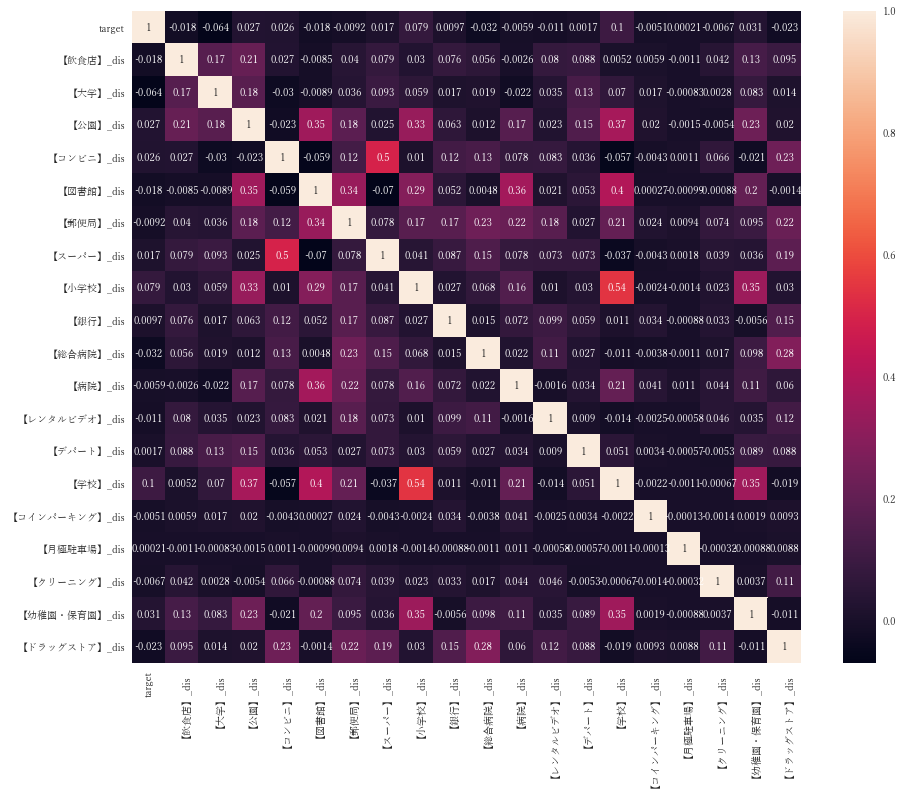

In [9]:
plt.figure(figsize=(15,12))
corr = train[['target']+fe1].corr()
sns.heatmap(corr,annot=True)

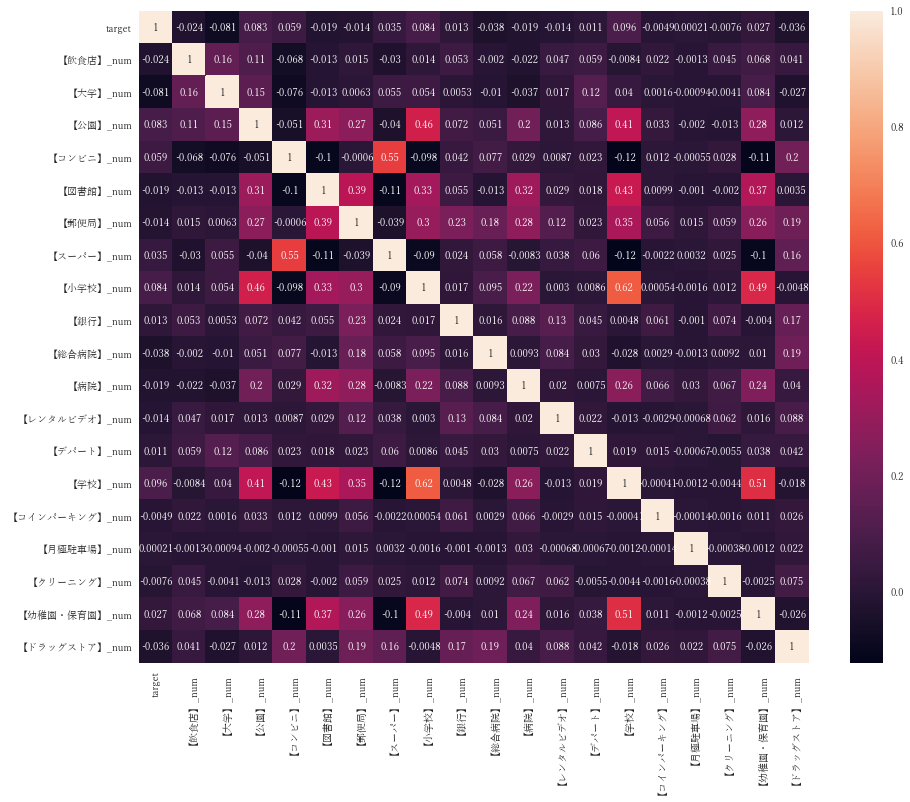

In [10]:
plt.figure(figsize=(15,12))
corr = train[['target']+fe2].corr()
sns.heatmap(corr,annot=True)

In [14]:
pd.concat([train[fe1].describe().reset_index(),test[fe1].describe().reset_index()])

index     【飲食店】_dis      【大学】_dis      【公園】_dis    【コンビニ】_dis  \
0  count  31470.000000  31470.000000  31470.000000  31470.000000   
1   mean     66.073657     37.421195     79.283603    193.996219   
2    std    328.323075    253.178139    294.433865    263.756092   
3    min      0.000000      0.000000      0.000000      0.000000   
4    25%      0.000000      0.000000      0.000000      0.000000   
5    50%      0.000000      0.000000      0.000000    117.000000   
6    75%      0.000000      0.000000      0.000000    302.000000   
7    max   9854.000000   6250.000000   8534.000000   5313.000000   
0  count  31262.000000  31262.000000  31262.000000  31262.000000   
1   mean     67.439639     37.261468     80.351161    193.554923   
2    std    331.499182    248.140394    298.685237    262.299728   
3    min      0.000000      0.000000      0.000000      0.000000   
4    25%      0.000000      0.000000      0.000000      0.000000   
5    50%      0.000000      0.000000      0.000000    119.500000   
6    75%      0.000000      0.000000      0.000000    301.000000   
7    max   9933.000000   6590.000000   6874.000000   4720.000000   

      【図書館】_dis     【郵便局】_dis    【スーパー】_dis     【小学校】_dis      【銀行】_dis  \
0  31470.000000  31470.000000  31470.000000  31470.000000  31470.000000   
1     29.360756     55.396092    279.371783     43.535875     19.516524   
2    166.409339    197.952578    330.025510    179.352486    125.067251   
3      0.000000      0.000000      0.000000      0.000000      0.000000   
4      0.000000      0.000000      0.000000      0.000000      0.000000   
5      0.000000      0.000000    221.000000      0.000000      0.000000   
6      0.000000      0.000000    449.000000      0.000000      0.000000   
7   5362.000000   4366.000000   5242.000000   4964.000000   4692.000000   
0  31262.000000  31262.000000  31262.000000  31262.000000  31262.000000   
1     28.360406     54.940791    282.807274     44.495874     20.894536   
2    161.502408    204.979723    333.512282    186.165996    129.296962   
3      0.000000      0.000000      0.000000      0.000000      0.000000   
4      0.000000      0.000000      0.000000      0.000000      0.000000   
5      0.000000      0.000000    223.000000      0.000000      0.000000   
6      0.000000      0.000000    451.000000      0.000000      0.000000   
7   4985.000000   5368.000000   6023.000000   5912.000000   2975.000000   

     【総合病院】_dis      【病院】_dis  【レンタルビデオ】_dis    【デパート】_dis      【学校】_dis  \
0  31470.000000  31470.000000   31470.000000  31470.000000  31470.000000   
1     46.634986     88.446870      12.934954     24.239752     34.978742   
2    249.456453    306.274710     124.846685    237.736322    185.638705   
3      0.000000      0.000000       0.000000      0.000000      0.000000   
4      0.000000      0.000000       0.000000      0.000000      0.000000   
5      0.000000      0.000000       0.000000      0.000000      0.000000   
6      0.000000      0.000000       0.000000      0.000000      0.000000   
7   5311.000000   5591.000000    4947.000000   9083.000000   5125.000000   
0  31262.000000  31262.000000   31262.000000  31262.000000  31262.000000   
1     48.611189     88.118387      13.802444     26.852313     34.159843   
2    253.924642    303.198239     133.421428    239.530005    184.834379   
3      0.000000      0.000000       0.000000      0.000000      0.000000   
4      0.000000      0.000000       0.000000      0.000000      0.000000   
5      0.000000      0.000000       0.000000      0.000000      0.000000   
6      0.000000      0.000000       0.000000      0.000000      0.000000   
7   4742.000000   5483.000000    5439.000000   6212.000000   5134.000000   

   【コインパーキング】_dis   【月極駐車場】_dis  【クリーニング】_dis  【幼稚園・保育園】_dis  【ドラッグストア】_dis  
0    31470.000000  31470.000000  31470.000000   31470.000000   31470.000000  
1        0.199905      0.013600      2.972958      24.610264      78.243756  
2        8.366075      2.412656     52.2121

### 室内設備

In [78]:
## 何が含まれているのか
fac = set()
facility = train['facilities'].apply(lambda x:str(x).split()).values
for lis in facility:
    for i in lis:
        i = i.replace('／','')
        fac.add(i)
fac

{'',
 '-',
 '24時間換気システム',
 '2面採光',
 '3面採光',
 'ウォークインクローゼット',
 'エアコン付',
 'エレベーター',
 'オール電化',
 'ガスその他',
 'ガス暖房',
 'クッションフロア',
 'シューズボックス',
 'タイル張り',
 'トランクルーム',
 'バリアフリー',
 'バルコニー',
 'フローリング',
 'プロパンガス',
 'ペアガラス',
 'ルーフバルコニー',
 'ロフト付き',
 '下水',
 '二世帯住宅',
 '二重サッシ',
 '井戸',
 '公営水道',
 '冷房',
 '出窓',
 '地下室',
 '室内洗濯機置場',
 '室外洗濯機置場',
 '専用庭',
 '床下収納',
 '床暖房',
 '排水その他',
 '敷地内ごみ置き場',
 '水道その他',
 '汲み取り',
 '洗濯機置場なし',
 '浄化槽',
 '石油暖房',
 '都市ガス',
 '防音室'}

In [93]:
## それぞれにフラグを立てる
fe = []
for f in fac:
    if f =='-' or f=='':
        continue
    train[f] = train.facilities.apply(lambda x: 1 if f in x else 0)
    test[f] = test.facilities.apply(lambda x: 1 if f in x else 0)
    fe.append(f)

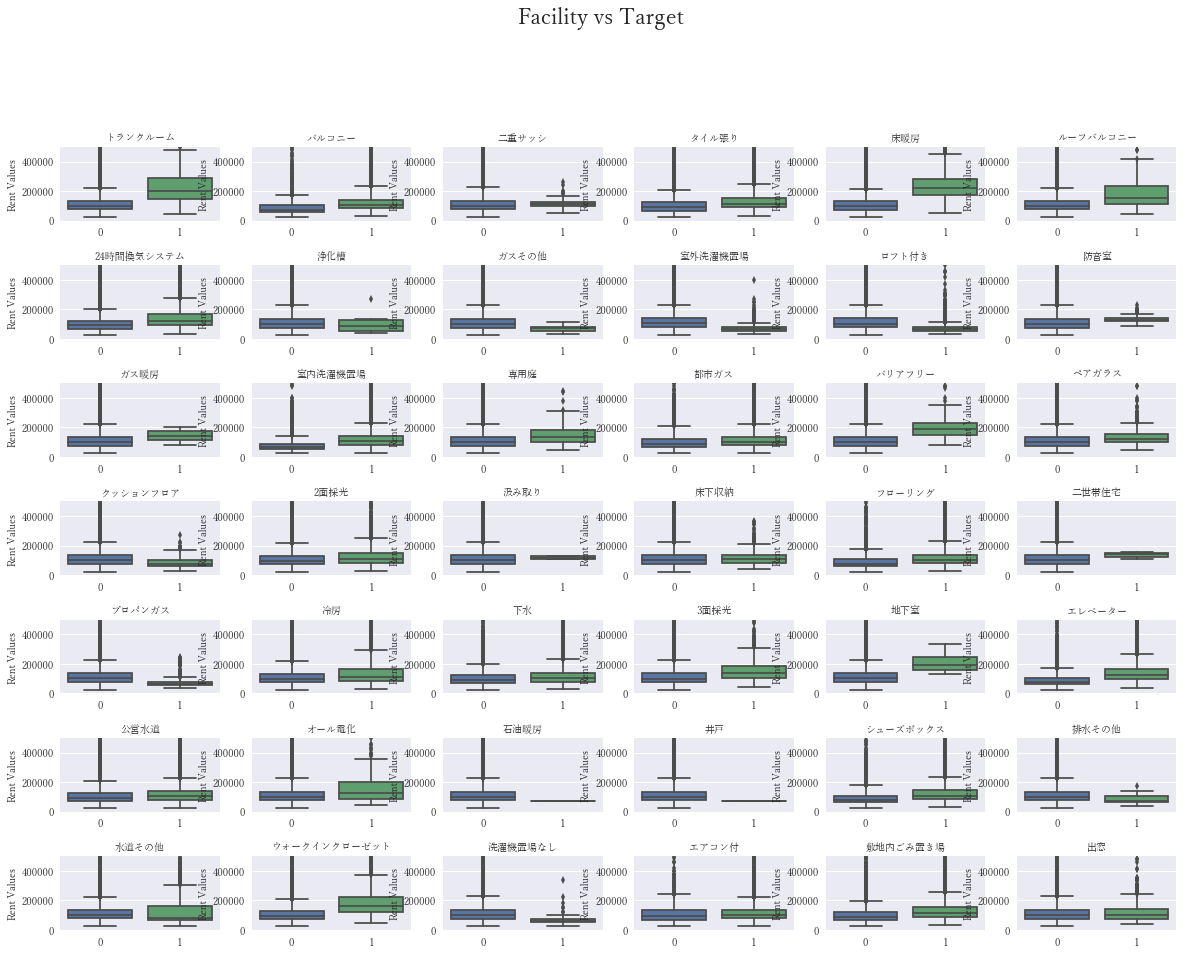

In [94]:
total = len(train)

plt.figure(figsize=(20,15))
plt.suptitle('Facility vs Target', fontsize=22)
for i in range(len(fe)):
    plt.subplot(7,6,i+1)
    g = sns.boxplot(x=fe[i], y='target', data=train )
    g.set_title(fe[i], fontsize=10)
    g.set_xlabel("", fontsize=10)
    g.set_ylabel("Rent Values", fontsize=10)
    g.set_ylim(0,500000)
    plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [95]:
for f in fe:
    print(train.groupby(f).target.describe())

           count           mean            std      min       25%       50%  \
トランクルーム                                                                       
0        30966.0  116229.930957   69222.955426  25000.0   76000.0  101000.0   
1          504.0  244880.755952  170191.958151  45000.0  148000.0  204000.0   

              75%        max  
トランクルーム                       
0        135000.0  2500000.0  
1        286250.0  1660000.0  
         count           mean           std      min      25%       50%  \
バルコニー                                                                     
0       6330.0   90592.689573  61592.828190  25000.0  60000.0   74000.0   
1      25140.0  125264.288703  74909.892261  30000.0  83000.0  107000.0   

            75%        max  
バルコニー                       
0      105000.0  1660000.0  
1      143000.0  2500000.0  
         count           mean           std      min      25%       50%  \
二重サッシ                                                              

1     151000.0  2500000.0  
        count           mean           std       min       25%       50%  \
汲み取り                                                                       
0     31465.0  118290.257206  73754.572308   25000.0   76000.0  102000.0   
1         5.0  118600.000000  10261.578826  108000.0  109000.0  118000.0   

           75%        max  
汲み取り                       
0     136000.0  2500000.0  
1     129000.0   129000.0  
        count           mean           std      min      25%       50%  \
床下収納                                                                     
0     30883.0  118240.729301  74061.846153  25000.0  76000.0  101500.0   
1       587.0  120898.637138  54797.407809  40000.0  82000.0  111000.0   

           75%        max  
床下収納                       
0     136500.0  2500000.0  
1     135000.0   368000.0  
          count           mean           std      min      25%       50%  \
フローリング                                                                

1      136000.0  2500000.0  
            count           mean           std      min      25%       50%  \
敷地内ごみ置き場                                                                     
0         14724.0  103312.442135  68179.377059  25000.0  67000.0   87000.0   
1         16746.0  131459.664696  75917.827980  34000.0  88000.0  113000.0   

               75%        max  
敷地内ごみ置き場                       
0         118500.0  1660000.0  
1         154000.0  2500000.0  
      count           mean           std      min      25%       50%  \
出窓                                                                     
0   30156.0  118430.354457  74104.283768  25000.0  76000.0  102000.0   
1    1314.0  115076.235921  65001.137115  37000.0  71000.0   98000.0   

         75%        max  
出窓                       
0   136000.0  2500000.0  
1   140000.0   590000.0  


物によってはかなり差が出る(トランクルーム、地下室)

### 駐車場

In [105]:
## 何が含まれているのか
par = set()
parking = train['parking'].apply(lambda x:str(x).split()).values
for lis in parking:
    for i in lis:
        par.add(i)
sorted(par)
par

{'31,104円',
 '5,184円',
 '(※空車状況は要確認)',
 '22,050円',
 '距離404m',
 '距離1384m',
 '(詳細はご連絡下さい。)',
 '15,700円(税込)',
 '(要確認)',
 '距離454m',
 '40,000円',
 '100円(税無)',
 '129,600円(税込)',
 '16,800円',
 '(屋根付き機械式',
 '25,920円',
 '距離135m',
 '17,300円',
 '距離162m',
 '20,571円',
 '空有(43台)',
 '30,400円(税込)',
 '13,997円',
 '(上記は最低料金。駐車場料金は区画によって異なります)',
 '19,500円',
 '3,780円',
 '(敷金礼金なし)',
 '距離450m',
 '26,250円',
 '500円(税別/初回))',
 '距離168m',
 '(最新の空き状況は弊社までお問合せください)',
 '27,360円(税込)',
 '普通～ハイルーフまで。敷金1ヶ月。空要確認)',
 '(空要確認、詳細はお問い合わせください。)',
 '(（税別）)',
 '距離197m',
 '47,520円',
 '(バイク置き場3，000円/月)',
 '距離453m',
 '31,000円',
 '距離175m',
 '10,500円',
 '屋内',
 '86,400円',
 '(別途契約要)',
 '(詳細はお問合せ下さい。)',
 '(※駐車場の最新の空きや料金は、サイズや区画によって異なります。詳細は、お問い合わせくださいませ。)',
 '(有料：要確認)',
 '19,400円',
 '(※詳細はお問い合わせください)',
 '(敷金礼金各１ヶ月)',
 '距離68m',
 '(※要空き確認)',
 '14,000円',
 '19,000円',
 '29,400円',
 '46,440円',
 '29,000円(税込)',
 '(屋外、形状(平置)、地上)',
 '(区画により金額が変わります。)',
 '(屋内、形状(平置))',
 '距離75m',
 '64,800円(税込)',
 '距離148m',
 '(敷地内です)',
 '(空き状況はご確認ください)',
 '距離158m',
 '距離

In [117]:
aa = pd.DataFrame()
aa['park'] = list(par)
aa

park
0                                               31,104円
1                                                5,184円
2                                           (※空車状況は要確認)
3                                               22,050円
4                                                距離404m
5                                               距離1384m
6                                          (詳細はご連絡下さい。)
7                                           15,700円(税込)
8                                                 (要確認)
9                                                距離454m
10                                              40,000円
11                                             100円(税無)
12                                         129,600円(税込)
13                                              16,800円
14                                             (屋根付き機械式
15                                              25,920円
16                                               距離135m
17                                              17,300円
18                                               距離162m
19                                              20,571円
20                                              空有(43台)
21                                          30,400円(税込)
22                                              13,997円
23                          (上記は最低料金。駐車場料金は区画によって異なります)
24                                              19,500円
25                                               3,780円
26                                             (敷金礼金なし)
27                                               距離450m
28                                              26,250円
29                                         500円(税別/初回))
30                                               距離168m
31                               (最新の空き状況は弊社までお問合せください)
32                                          27,360円(税込)
33                               普通～ハイルーフまで。敷金1ヶ月。空要確認)
34                                (空要確認、詳細はお問い合わせください。)
35                                               (（税別）)
36                                               距離197m
37                                              47,520円
38                                     (バイク置き場3，000円/月)
39                                               距離453m
40                                              31,000円
41                                               距離175m
42                                              10,500円
43                                                   屋内
44                                              86,400円
45                                              (別途契約要)
46                                        (詳細はお問合せ下さい。)
47    (※駐車場の最新の空きや料金は、サイズや区画によって異なります。詳細は、お問い合わせください...
48                                             (有料：要確認)
49                                              19,400円
50                                     (※詳細はお問い合わせください)
51                                           (敷金礼金各１ヶ月)
52                                                距離68m
53                                             (※要空き確認)
54                                              14,000円
55                                              19,000円
56                                              29,400円
57                                              46,440円
58                                          29,000円(税込)
59                                       (屋外、形状(平置)、地上)
60                                     (区画により金額が変わります。)
61                                          (屋内、形状(平置))
62                                                距離75m
63                                          64,800円(税込)
64                                               距離148m
65                                              (敷地内です)
66                                       (空き状況はご確認ください)
67                                               距離158m
68                                               距離157m
69                                               距離380m
70                                          (1,080円/月～)
71                 

In [112]:
park = ['駐輪場','駐車場','バイク置き場']

In [130]:
%%time
fe = []
for p in tqdm(park):
    ## 周辺環境との最短距離
    train[p] = train.parking.apply(lambda x: x.split()[x.split().index(p)+1].split('(')[0] if p in x.split() else '-')
    test[p] = test.parking.apply(lambda x: x.split()[x.split().index(p)+1].split('(')[0] if p in x.split() else '-')
    fe.append(p)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.76it/s]


Wall time: 513 ms


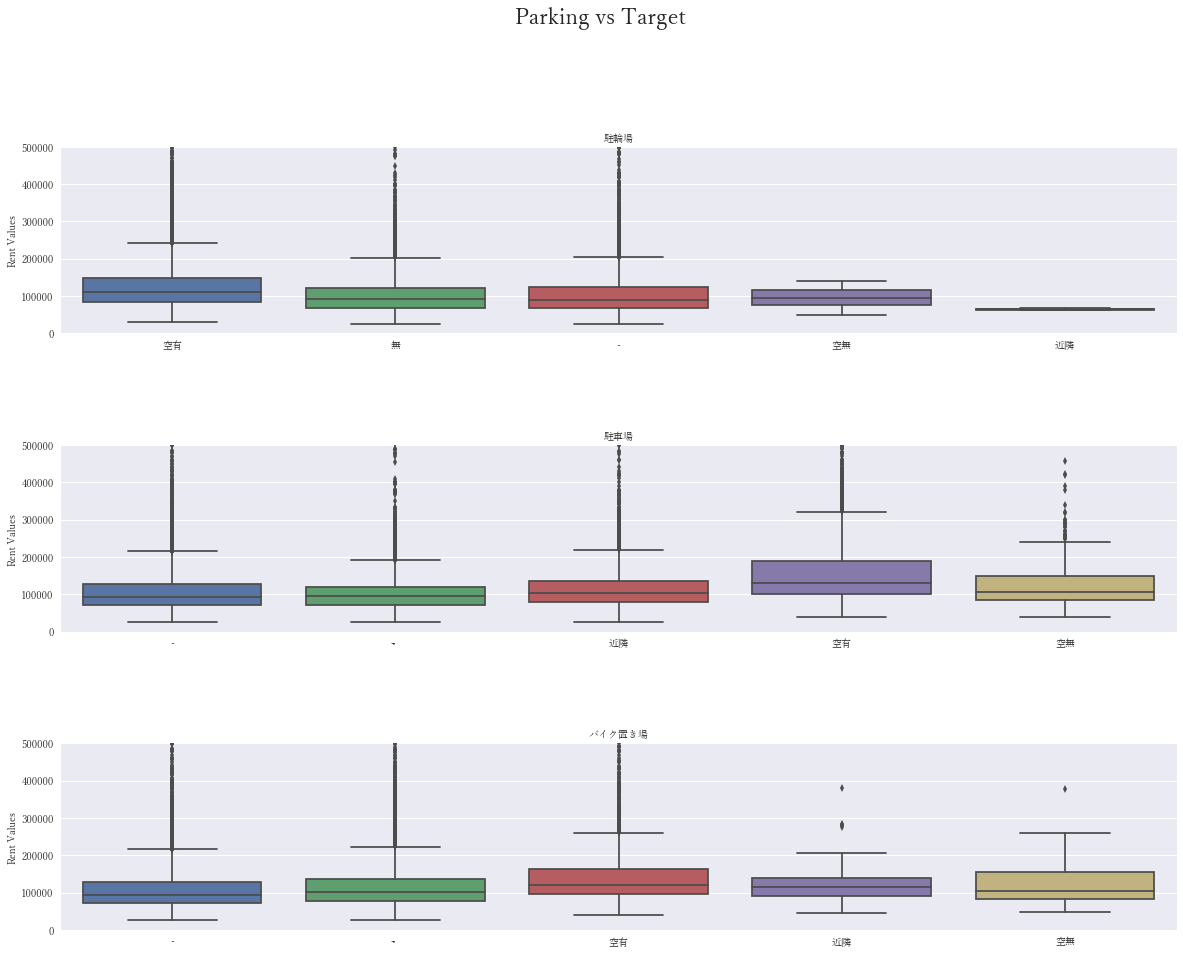

In [132]:
total = len(train)

plt.figure(figsize=(20,15))
plt.suptitle('Parking vs Target', fontsize=22)
for i in range(len(fe)):
    plt.subplot(3,1,i+1)
    g = sns.boxplot(x=fe[i], y='target', data=train )
    g.set_title(fe[i], fontsize=10)
    g.set_xlabel("", fontsize=10)
    g.set_ylabel("Rent Values", fontsize=10)
    g.set_ylim(0,500000)
    plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [134]:
for f in fe:
    print(train.groupby(f).target.describe())

       count           mean           std      min      25%       50%  \
駐輪場                                                                     
-    10450.0  108846.449474  80294.709687  25000.0  69000.0   90000.0   
無     4513.0  107758.192998  70722.897244  26000.0  68000.0   91000.0   
空有   16490.0  127186.738690  68979.520025  30000.0  85000.0  110000.0   
空無      15.0   93366.666667  27770.402195  48500.0  74500.0   95000.0   
近隣       2.0   64000.000000   4242.640687  61000.0  62500.0   64000.0   

          75%        max  
駐輪場                       
-    123000.0  2500000.0  
無    122000.0   950000.0  
空有   148000.0  1390000.0  
空無   115000.0   140000.0  
近隣    65500.0    67000.0  
       count           mean            std      min       25%       50%  \
駐車場                                                                       
-    10053.0  108868.374217   64268.525231  26200.0   70000.0   92000.0   
無     8597.0  103909.595324   56915.827488  25000.0   72000.0   94000.0   

### アクセス
**一回保留**  
- [東京23区の家賃相場が安い駅](https://suumo.jp/journal/2019/03/18/163064/)  

最寄り駅はどこか、何分かかるか、バス使うのか

In [185]:
## 何が含まれているのか
ac = set()
n = 0
access = train['access'].apply(lambda x: x.split()[n] if len(x.split())>=n+1 else '-').values
for lis in access:
    ac.add(lis)
ac

{'つくばエクスプレス',
 'ゆりかもめ',
 'りんかい線',
 '中央線（快速）',
 '丸ノ内線(中野坂上－方南町)',
 '丸ノ内線(池袋－荻窪)',
 '京急本線',
 '京急空港線',
 '京成成田空港線',
 '京成押上線',
 '京成本線',
 '京成金町線',
 '京浜東北線',
 '京王井の頭線',
 '京王新線',
 '京王線',
 '京葉線(東京－蘇我)',
 '副都心線',
 '北総線',
 '千代田線',
 '半蔵門線',
 '南北線',
 '埼京線',
 '小田急小田原線',
 '山手線',
 '常磐線',
 '常磐線快速',
 '日暮里・舎人ライナー',
 '日比谷線',
 '有楽町線',
 '東京モノレール羽田線',
 '東北新幹線',
 '東北本線（宇都宮線）',
 '東急世田谷線',
 '東急多摩川線',
 '東急大井町線',
 '東急東横線',
 '東急池上線',
 '東急田園都市線',
 '東急目黒線',
 '東武スカイツリーライン',
 '東武亀戸線',
 '東武伊勢崎線(押上－曳舟)',
 '東武大師線',
 '東武東上線',
 '東海道新幹線',
 '東海道本線',
 '東西線',
 '横須賀線',
 '湘南新宿ライン(東北本線－横須賀線)',
 '湘南新宿ライン(高崎線－東海道本線)',
 '総武本線',
 '総武線・中央線（各停）',
 '西武新宿線',
 '西武有楽町線',
 '西武池袋線',
 '西武豊島線',
 '都営三田線',
 '都営大江戸線',
 '都営新宿線',
 '都営浅草線',
 '都電荒川線',
 '銀座線',
 '高崎線'}

In [43]:
## 最寄り駅を線、駅名、かかる時間に分ける
train['line'] = train['access'].apply(lambda x: x.split()[0])
test['line'] = test['access'].apply(lambda x: x.split()[0])

train['station'] = train['access'].apply(lambda x: x.split()[1])
test['station'] = test['access'].apply(lambda x: x.split()[1])


train['cost'] = train['access'].apply(lambda x: x.split()[2].replace('/',''))
test['cost'] = test['access'].apply(lambda x: x.split()[2].replace('/',''))

train['cost2'] = train['access'].apply(lambda x: x.split()[3] if len(x.split())>=4 else '')
test['cost2'] = test['access'].apply(lambda x: x.split()[3] if len(x.split())>=4 else '')

train['cost2'] = train.cost2.apply(lambda x: x if re.search("[0-9]",x) else  '')
test['cost2'] = test.cost2.apply(lambda x: x if re.search("[0-9]",x) else  '')

train['cost'] = train['cost'] + train['cost2']
test['cost'] = test['cost'] + test['cost2']

train.drop('cost2',axis=1, inplace=True)
test.drop('cost2',axis=1, inplace=True)

In [44]:
## もっと近い駅がある場合
train.loc[610,'station'] = '武蔵関駅'
train.loc[610,'line'] = '西武新宿線'
train.loc[610,'cost'] = '徒歩8分'
train.loc[682,'station'] = '篠崎駅'
train.loc[682,'line'] = '都営新宿線'
train.loc[682,'cost'] = '徒歩23分'
train.loc[943,'station'] = '桜上水駅'
train.loc[943,'line'] = '京王線'
train.loc[943,'cost'] = '徒歩4分'
train.loc[1548,'station'] = '武蔵関駅'
train.loc[1548,'line'] = '西武新宿線'
train.loc[1548,'cost'] = '徒歩7分'
train.loc[1924,'station'] = '東中野駅'
train.loc[1924,'line'] = '総武線・中央線（各停）'
train.loc[1924,'cost'] = '徒歩12分'
train.loc[2012,'station'] = '武蔵関駅'
train.loc[2012,'line'] = '西武新宿線'
train.loc[2012,'cost'] = '徒歩8分'
train.loc[2474,'station'] = '谷塚駅'
train.loc[2474,'line'] = '東武スカイツリーライン'
train.loc[2474,'cost'] = '徒歩26分'
train.loc[3926,'station'] = '扇大橋駅'
train.loc[3926,'line'] = '日暮里・舎人ライナー'
train.loc[3926,'cost'] = '扇大橋駅'
train.loc[5369,'station'] = '武蔵関駅'
train.loc[5369,'line'] = '西武新宿線'
train.loc[5369,'cost'] = '徒歩8分'
train.loc[5875,'station'] = '池尻大橋駅'
train.loc[5875,'line'] = '東急田園都市線'
train.loc[5875,'cost'] = '徒歩14分'
train.loc[6463,'station'] = '扇大橋駅'
train.loc[6463,'line'] = '日暮里・舎人ライナー'
train.loc[6463,'cost'] = '徒歩4分'
train.loc[6591,'station'] = '武蔵関駅'
train.loc[6591,'line'] = '西武新宿線'
train.loc[6591,'cost'] = '徒歩8分'
train.loc[7630,'station'] = '武蔵関駅'
train.loc[7630,'line'] = '西武新宿線'
train.loc[7630,'cost'] = '徒歩3分'
train.loc[8003,'station'] = '新中野駅'
train.loc[8003,'line'] = '丸ノ内線(池袋－荻窪)'
train.loc[8003,'cost'] = '徒歩9分'
train.loc[8709,'station'] = '八潮駅'
train.loc[8709,'line'] = 'つくばエクスプレス'
train.loc[8709,'cost'] = '徒歩22分'
train.loc[8869,'station'] = '八潮駅'
train.loc[8869,'line'] = 'つくばエクスプレス'
train.loc[8869,'cost'] = '徒歩14分'
train.loc[9338,'station'] = '武蔵関駅'
train.loc[9338,'line'] = '西武新宿線'
train.loc[9338,'cost'] = '徒歩7分'
train.loc[9503,'station'] = '葛西臨海公園駅'
train.loc[9503,'line'] = '京葉線(東京－蘇我)'
train.loc[9503,'cost'] = '徒歩13分'
train.loc[9848,'station'] = '葛西臨海公園駅'
train.loc[9848,'line'] = '京葉線(東京－蘇我)'
train.loc[9848,'cost'] = '徒歩22分'
train.loc[12146,'station'] = '上石神井駅'
train.loc[12146,'line'] = '西武新宿線'
train.loc[12146,'cost'] = '徒歩8分'
train.loc[12557,'station'] = '北綾瀬駅'
train.loc[12557,'line'] = '千代田線'
train.loc[12557,'cost'] = '徒歩23分'
train.loc[12581,'station'] = '町屋(東京メトロ)駅'
train.loc[12581,'line'] = '千代田線'
train.loc[12581,'cost'] = '徒歩8分'
train.loc[12808,'station'] = '東中野駅'
train.loc[12808,'line'] = '都営大江戸線'
train.loc[12808,'cost'] = '徒歩13分'
train.loc[12823,'station'] = '沼袋駅'
train.loc[12823,'line'] = '西武新宿線'
train.loc[12823,'cost'] = '徒歩12分'
train.loc[13123,'station'] = '八潮駅'
train.loc[13123,'line'] = 'つくばエクスプレス'
train.loc[13123,'cost'] = '徒歩22分'
train.loc[13507,'station'] = '亀有駅'
train.loc[13507,'line'] = '常磐線'
train.loc[13507,'cost'] = '徒歩25分'
train.loc[15240,'station'] = '上石神井駅'
train.loc[15240,'line'] = '西武新宿線'
train.loc[15240,'cost'] = '徒歩11分'
train.loc[16308,'station'] = '祖師ケ谷大蔵駅'
train.loc[16308,'line'] = '小田急小田原線'
train.loc[16308,'cost'] = '徒歩18分'
train.loc[17262,'station'] = '武蔵関駅'
train.loc[17262,'line'] = '西武新宿線'
train.loc[17262,'cost'] = '徒歩9分'
train.loc[17280,'station'] = '竹ノ塚駅'
train.loc[17280,'line'] = '東武スカイツリーライン'
train.loc[17280,'cost'] = '徒歩34分'
train.loc[17408,'station'] = '中井駅'
train.loc[17408,'line'] = '西武新宿線'
train.loc[17408,'cost'] = '徒歩11分'
train.loc[18051,'station'] = '八潮駅'
train.loc[18051,'line'] = 'つくばエクスプレス'
train.loc[18051,'cost'] = '徒歩22分'
train.loc[18998,'station'] = '扇大橋駅'
train.loc[18998,'line'] = '日暮里・舎人ライナー'
train.loc[18998,'cost'] = '徒歩17分'
train.loc[19724,'station'] = '池尻大橋駅'
train.loc[19724,'line'] = '東急田園都市線'
train.loc[19724,'cost'] = '徒歩14分'
train.loc[20556,'station'] = '武蔵関駅'
train.loc[20556,'line'] = '西武新宿線'
train.loc[20556,'cost'] = '徒歩6分'
train.loc[21102,'station'] = '扇大橋駅'
train.loc[21102,'line'] = '日暮里・舎人ライナー'
train.loc[21102,'cost'] = '徒歩15分'
train.loc[21491,'station'] = '扇大橋駅'
train.loc[21491,'line'] = '日暮里・舎人ライナー'
train.loc[21491,'cost'] = '徒歩18分'
train.loc[21923,'station'] = '武蔵関駅'
train.loc[21923,'line'] = '西武新宿線'
train.loc[21923,'cost'] = '徒歩6分'
train.loc[24103,'station'] = '池尻大橋駅'
train.loc[24103,'line'] = '東急田園都市線'
train.loc[24103,'cost'] = '徒歩14分'
train.loc[24576,'station'] = '六町駅'
train.loc[24576,'line'] = 'つくばエクスプレス'
train.loc[24576,'cost'] = '徒歩19分'
train.loc[25446,'station'] = '志村三丁目駅'
train.loc[25446,'line'] = '都営三田線'
train.loc[25446,'cost'] = '徒歩5分'
train.loc[27410,'station'] = '竹ノ塚駅'
train.loc[27410,'line'] = '東武スカイツリーライン'
train.loc[27410,'cost'] = '徒歩34分'
train.loc[28380,'station'] = '武蔵関駅'
train.loc[28380,'line'] = '西武新宿線'
train.loc[28380,'cost'] = '徒歩10分'
train.loc[29579,'station'] = '平和島駅'
train.loc[29579,'line'] = '京急本線'
train.loc[29579,'cost'] = '徒歩19分'
train.loc[30139,'station'] = '西新井駅'
train.loc[30139,'line'] = '東武スカイツリーライン'
train.loc[30139,'cost'] = '徒歩23分'
train.loc[30500,'station'] = '上石神井駅'
train.loc[30500,'line'] = '西武新宿線'
train.loc[30500,'cost'] = '徒歩13分'
train.loc[31298,'station'] = '梅島駅'
train.loc[31298,'line'] = '東武スカイツリーライン'
train.loc[31298,'cost'] = '徒歩17分'

In [45]:
## テストデータの修正
test.loc[4177,'station'] = '葛西臨海公園駅'
test.loc[4177,'line'] = '京葉線(東京－蘇我)'
test.loc[4177,'cost'] = '徒歩19分'
test.loc[4448,'station'] = '千川駅'
test.loc[4448,'line'] = '有楽町線'
test.loc[4448,'cost'] = '徒歩2分'
test.loc[4533,'station'] = '池尻大橋駅'
test.loc[4533,'line'] = '東急田園都市線'
test.loc[4533,'cost'] = '徒歩14分'
test.loc[7599,'station'] = '八潮駅'
test.loc[7599,'line'] = 'つくばエクスプレス'
test.loc[7599,'cost'] = '徒歩18分'
test.loc[7813,'station'] = '池尻大橋駅'
test.loc[7813,'line'] = '東急田園都市線'
test.loc[7813,'cost'] = '徒歩14分'
test.loc[8808,'station'] = '葛西臨海公園駅'
test.loc[8808,'line'] = '京葉線(東京－蘇我)'
test.loc[8808,'cost'] = '徒歩27分'
test.loc[8933,'station'] = '武蔵関駅'
test.loc[8933,'line'] = '西武新宿線'
test.loc[8933,'cost'] = '徒歩9分'
test.loc[9729,'station'] = '昭和島駅'
test.loc[9729,'line'] = '東京モノレール羽田線'
test.loc[9729,'cost'] = '徒歩10分'
test.loc[11054,'station'] = '千歳船橋駅'
test.loc[11054,'line'] = '小田急小田原線'
test.loc[11054,'cost'] = '徒歩15分'
test.loc[11499,'station'] = '扇大橋駅'
test.loc[11499,'line'] = '日暮里・舎人ライナー'
test.loc[11499,'cost'] = '徒歩3分'
test.loc[12589,'station'] = '扇大橋駅'
test.loc[12589,'line'] = '日暮里・舎人ライナー'
test.loc[12589,'cost'] = '徒歩18分'
test.loc[12906,'station'] = '西新井駅'
test.loc[12906,'line'] = '東武スカイツリーライン'
test.loc[12906,'cost'] = '徒歩18分'
test.loc[13711,'station'] = '保谷駅'
test.loc[13711,'line'] = '西武池袋線'
test.loc[13711,'cost'] = '徒歩19分'
test.loc[13812,'station'] = '扇大橋駅'
test.loc[13812,'line'] = '日暮里・舎人ライナー'
test.loc[13812,'cost'] = '徒歩17分'
test.loc[15216,'station'] = '扇大橋駅'
test.loc[15216,'line'] = '日暮里・舎人ライナー'
test.loc[15216,'cost'] = '徒歩15分'
test.loc[16773,'station'] = '王子駅'
test.loc[16773,'line'] = '京浜東北線'
test.loc[16773,'cost'] = '徒歩12分'
test.loc[18146,'station'] = '小台駅'
test.loc[18146,'line'] = '都電荒川線'
test.loc[18146,'cost'] = '徒歩19分'
test.loc[18997,'station'] = '落合南長崎駅'
test.loc[18997,'line'] = '都営大江戸線'
test.loc[18997,'cost'] = '徒歩6分'
test.loc[19859,'station'] = '武蔵関駅'
test.loc[19859,'line'] = '西武新宿線'
test.loc[19859,'cost'] = '徒歩8分'
test.loc[20195,'station'] = '葛西臨海公園駅'
test.loc[20195,'line'] = '京葉線(東京－蘇我)'
test.loc[20195,'cost'] = '徒歩22分'
test.loc[20462,'station'] = '西新井駅'
test.loc[20462,'line'] = '東武スカイツリーライン'
test.loc[20462,'cost'] = '徒歩19分'
test.loc[21160,'station'] = '扇大橋駅'
test.loc[21160,'line'] = '日暮里・舎人ライナー'
test.loc[21160,'cost'] = '徒歩5分'
test.loc[22287,'station'] = '中野新橋駅'
test.loc[22287,'line'] = '丸ノ内線(中野坂上－方南町)'
test.loc[22287,'cost'] = '徒歩10分'
test.loc[22584,'station'] = '西荻窪駅'
test.loc[22584,'line'] = '中央線（快速）'
test.loc[22584,'cost'] = '徒歩20分'
test.loc[23008,'station'] = '池尻大橋駅'
test.loc[23008,'line'] = '東急田園都市線'
test.loc[23008,'cost'] = '徒歩14分'
test.loc[23060,'station'] = '下井草駅'
test.loc[23060,'line'] = '西武新宿線'
test.loc[23060,'cost'] = '徒歩2分'
test.loc[24518,'station'] = '扇大橋駅'
test.loc[24518,'line'] = '日暮里・舎人ライナー'
test.loc[24518,'cost'] = '徒歩16分'
test.loc[24744,'station'] = '祖師ケ谷大蔵駅'
test.loc[24744,'line'] = '小田急小田原線'
test.loc[24744,'cost'] = '徒歩14分'
test.loc[26054,'station'] = '目黒駅'
test.loc[26054,'line'] = '山手線'
test.loc[26054,'cost'] = '徒歩11分'
test.loc[26637,'station'] = '西荻窪駅'
test.loc[26637,'line'] = '中央線（快速）'
test.loc[26637,'cost'] = '徒歩20分'
test.loc[26852,'station'] = '浮間舟渡駅'
test.loc[26852,'line'] = '埼京線'
test.loc[26852,'cost'] = '徒歩9分'
test.loc[27143,'station'] = '上石神井駅'
test.loc[27143,'line'] = '西武新宿線'
test.loc[27143,'cost'] = '徒歩11分'
test.loc[29605,'station'] = '六町駅'
test.loc[29605,'line'] = 'つくばエクスプレス'
test.loc[29605,'cost'] = '徒歩35分'
test.loc[30300,'station'] = '上石神井駅'
test.loc[30300,'line'] = '西武新宿線'
test.loc[30300,'cost'] = '徒歩4分'

In [46]:
train['use_bus'] = train.cost.apply(lambda x: 1 if ('バス' in x) or ('車' in x) else 0)
test['use_bus'] = test.cost.apply(lambda x: 1 if ('バス' in x) or ('車' in x) else 0)

In [47]:
train['cost'] = train.cost.apply(lambda x: re.findall('[0-9]分|[0-9][0-9]分', x))
test['cost'] = test.cost.apply(lambda x: re.findall('[0-9]分|[0-9][0-9]分', x))

train['cost'] = train.cost.apply(lambda x: int(x[0].replace('分','')) if len(x)==1 else
                                            int(x[0].replace('分',''))+int(x[1].replace('分',''))if len(x)==2 else 0)
test['cost'] = test.cost.apply(lambda x: int(x[0].replace('分','')) if len(x)==1 else
                                            int(x[0].replace('分',''))+int(x[1].replace('分',''))if len(x)==2 else 0)

<Figure size 864x576 with 0 Axes>

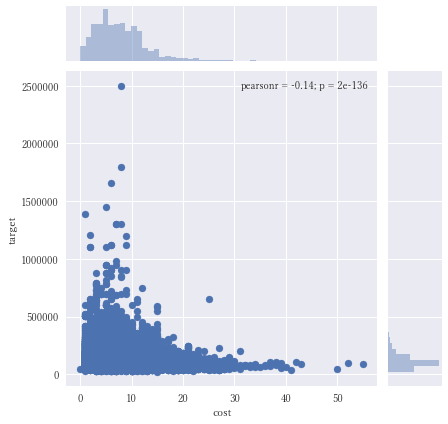

In [48]:
plt.figure(figsize=(12,8))
sns.jointplot(x='cost',y='target',data=train)

In [468]:
## 駅名をcsvファイルに
#station = pd.concat([train[['id','station']],test[['id','station']]])
#station = station.drop_duplicates(subset='station')
#print(len(station))
#station.to_csv('../input/station.csv',index=False,encoding='cp932')

In [28]:
## 駅の緯度経度
sta = pd.read_table('../input/station.txt',encoding='cp932',delimiter=',')
print(len(sta))
print(sta.lat.nunique())
sta.tail()

476
472


station        lat         lon
471     整備場駅  35.555180  139.753410
472      鶴瀬駅  35.845811  139.539530
473  東尾久三丁目駅  35.745681  139.773899
474   国際展示場駅  35.634401  139.791583
475    武蔵小杉駅  35.576633  139.659466

In [37]:
## 最寄り駅の緯度経度追加
## lon, latのマッピング
lat_map = sta.groupby('station')['lat'].max()
lon_map = sta.groupby('station')['lon'].max()
train['sta_lat'] = train.station.map(lat_map)
train['sta_lon'] = train.station.map(lon_map)

test['sta_lat'] = test.station.map(lat_map)
test['sta_lon'] = test.station.map(lon_map)

In [38]:
## 緯度経度のサインコサイン変換
from math import sin, cos
train['sin_sta_lat'] = train.sta_lat.apply(lambda x: sin(radians(x))
train['cos_sta_lon'] = train.sta_lon.apply(lambda x: cos(radians(x))

test['sin_sta_lat'] = test.sta_lat.apply(lambda x: sin(radians(x))
test['cos_sta_lon'] = test.sta_lon.apply(lambda x: cos(radians(x))

## 距離を求める関数
# 国会議事堂の緯度経度[35.6759323, 139.7450316]
import math
import pyproj
from geopy.distance import great_circle, vincenty

# 赤道半径をWGS84準拠で設定
g = pyproj.Geod(ellps='WGS84')

train['station_dis'] = train.apply(lambda x: vincenty((x['loc_lat'],x['loc_lon']),(x['sta_lat'],x['sta_lon'])).meters, axis=1)
test['station_dis'] = test.apply(lambda x: vincenty((x['loc_lat'],x['loc_lon']),(x['sta_lat'],x['sta_lon'])).meters, axis=1)

## 距離が明らかにおかしかった。
train.loc[24812,'station_dis'] = 118.60
train.loc[24401,'station_dis'] = 118.60


 mu = 582.98 and sigma = 354.77



((array([-4.08513702, -3.87431282, -3.75917019, ...,  3.75917019,
          3.87431282,  4.08513702]),
  array([  11.4841566 ,   11.4841566 ,   11.4841566 , ..., 3672.60729449,
         3753.01974465, 3875.48170001])),
 (334.95276175561264, 582.9806031684435, 0.9440276178932049))

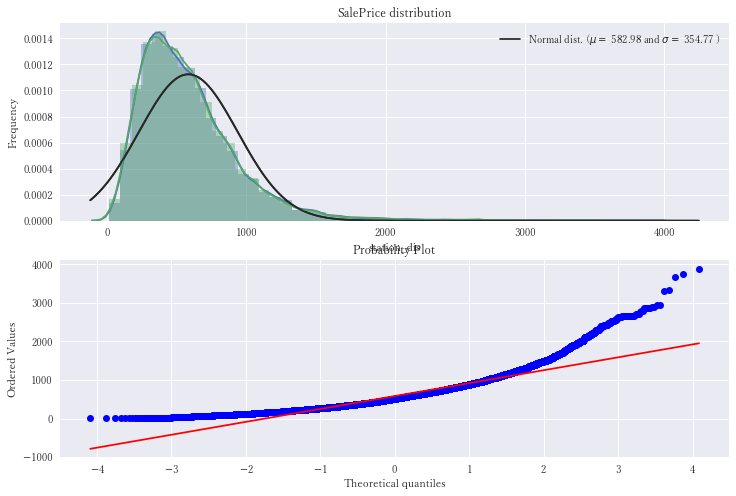

In [39]:
## 確認
plt.figure(figsize=(12,8))
plt.subplot(211)
g = sns.distplot(train['station_dis'],fit=norm)
g = sns.distplot(test['station_dis'],fit=norm)
(mu,sigma) = norm.fit(train['station_dis'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
g.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
g.set_ylabel('Frequency')
g.set_title('SalePrice distribution')

plt.subplot(212)
stats.probplot(train['station_dis'],plot=plt)

In [40]:
pd.concat([train.station_dis.describe().reset_index(),test.station_dis.describe().reset_index()],axis=1)

index   station_dis  index   station_dis
0  count  31470.000000  count  31262.000000
1   mean    582.980603   mean    580.750103
2    std    354.773236    std    354.791730
3    min     11.484157    min     11.484157
4    25%    333.330787    25%    331.920212
5    50%    511.980445    50%    510.579447
6    75%    747.988819    75%    744.752106
7    max   3875.481700    max   4117.745170

In [41]:
## 賃貸を地図に表示
import folium
sta_map = train.groupby('station')[['target','sta_lat','sta_lon']].median()

map = folium.Map(location=[35.638697, 139.683262], zoom_start=11)
 
for i, r in sta_map.iterrows():
    folium.CircleMarker(location=[r['sta_lat'], r['sta_lon']], popup=r['target'],
                        color='crimson',fill=True,radius=r['target']/50000).add_to(map)
map

<Figure size 864x576 with 0 Axes>

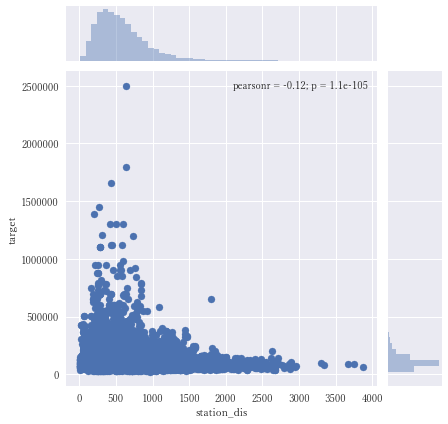

In [42]:
plt.figure(figsize=(12,8))
sns.jointplot(x='station_dis',y='target',data=train)

#### 駅の乗車人数

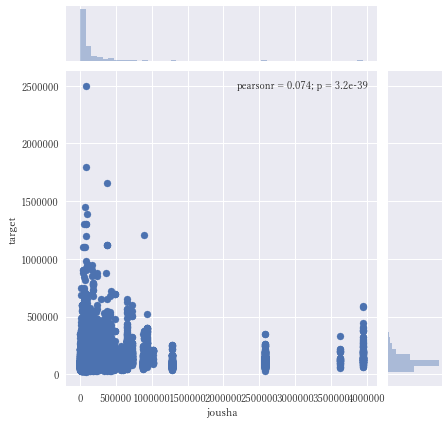

In [49]:
## 駅の乗車人数追加
df = pd.read_csv('../input/tokyo23/station_jousha.csv',encoding='utf-8')
train['station'] = train.station.apply(lambda x: x.replace('(舎人ライナー)','').replace('(東京都)','')\
                                      .replace('(東京メトロ)','').replace('(都営線)','').replace('(西武線)','')\
                                      .replace('(西武線)','').replace('(千葉県)','').replace('(ＴＸ)','').replace('(都電荒川線)',''))
test['station'] = test.station.apply(lambda x: x.replace('(舎人ライナー)','').replace('(東京都)','')\
                                      .replace('(東京メトロ)','').replace('(都営線)','').replace('(西武線)','')\
                                      .replace('(西武線)','').replace('浦安(千葉県)','').replace('(ＴＸ)','').replace('(都電荒川線)',''))

## マッピング
s_map = df.groupby('station').jousha_num.sum()
train['jousha'] = train.station.map(s_map)
test['jousha'] = test.station.map(s_map)
sns.jointplot(x='jousha',y='target',data=train[train['jousha']>0])

### クラスタリング

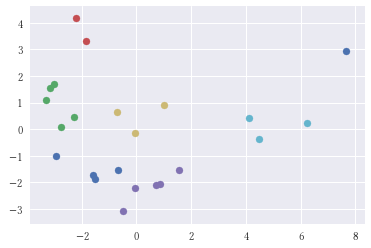

In [51]:

## 区の情報を無理やり追加
## データ読み込み
df1 = pd.read_csv('../input/tokyo23/area.csv',encoding='utf-8')
df2 = pd.read_csv('../input/tokyo23/daytime_popu.csv',encoding='utf-8')
df3 = pd.read_csv('../input/tokyo23/dwelling.csv',encoding='utf-8')
df4 = pd.read_csv('../input/tokyo23/households.csv',encoding='utf-8')
df5 = pd.read_csv('../input/tokyo23/income.csv',encoding='utf-8')
df6 = pd.read_csv('../input/tokyo23/move_popu.csv',encoding='utf-8')
df7 = pd.read_csv('../input/tokyo23/office.csv',encoding='utf-8')
df8 = pd.read_csv('../input/tokyo23/population.csv',encoding='utf-8')
df9 = pd.read_csv('../input/tokyo23/popu_tran.csv',encoding='shift-jis')
df10 = pd.read_csv('../input/tokyo23/revenue.csv',encoding='utf-8')
df11 = pd.read_csv('../input/tokyo23/households_num.csv',encoding='utf-8')

## 各データ結合
data = pd.merge(df1,df2,on='地域',how='outer')
data = pd.merge(data,df3,on='地域',how='outer')
data = pd.merge(data,df4,on='地域',how='outer')
data = pd.merge(data,df5,on='地域',how='outer')
data = pd.merge(data,df6,on='地域',how='outer')
data = pd.merge(data,df7,on='地域',how='outer')
data = pd.merge(data,df8,on='地域',how='outer')
data = pd.merge(data,df9,on='地域',how='outer')
data = pd.merge(data,df10,on='地域',how='outer')
data = pd.merge(data,df11,on='地域',how='outer')

data = data.rename(columns={'地域':'city'})
data = data.query('city!="区部"')

data = data[['city','総面積','昼間人口','住居総数','年収','事業所数','2020年','総世帯数']]

## 訓練データについて
train = pd.read_csv('../input/train.csv')
train = train.rename(columns={'賃料':'target','所在地':'location','アクセス':'access',
                              '間取り':'floor_plan','築年数':'age','方角':'direction','面積':'area','所在階':'Floor',
                              'バス・トイレ':'Bath_Toilet','キッチン':'kitchen','放送・通信':'broadcast','室内設備':'facilities',
                              '駐車場':'parking','周辺環境':'env','建物構造':'structure','契約期間':'C_year'})

## 東京都という文字を抜く
train['location'] = train['location'].apply(lambda x: x.replace('東京都',''))

## 市町村をわける
siku = ["千代田区","中央区","港区","新宿区","文京区","台東区","墨田区","江東区","品川区","目黒区","大田区","世田谷区","渋谷区","中野区",
        "杉並区","豊島区","北区","荒川区","板橋区","練馬区","足立区","葛飾区","江戸川区","八王子市","立川市","武蔵野市","三鷹市","青梅市",
        "府中市","昭島市","調布市","町田市","小金井市","小平市","日野市","東村山市","国分寺市","国立市","福生市","狛江市","東大和市",
        "清瀬市","東久留米市","武蔵村山市","多摩市","稲城市","羽村市","あきる野市","西東京市","瑞穂町","日の出町","檜原村","奥多摩町","大島町",
        "利島村","新島村","神津島村","三宅村","御蔵島村","八丈町","青ヶ島村","小笠原村",]

train['city'] = train['location'].apply(lambda x: [s for s in siku if s in x][0])
train.drop('location',axis=1,inplace=True)

df = train.groupby('city').target.describe().sort_values('mean').reset_index()
df = pd.merge(df,data,on='city')
df.drop('count',axis=1,inplace=True)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(df.drop('city',axis=1).values)

## 次元圧縮
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X)

df['x'] = X_transformed[:,0]
df['y'] = X_transformed[:,1]

from sklearn.cluster import KMeans
pred = KMeans(n_clusters=7).fit_predict(X_transformed)
df['cluster'] = pred

## 描画
for i in df.cluster.unique():
    plt.scatter(df.query('cluster==@i')['x'],df.query('cluster==@i')['y'])

In [52]:
df[['city','cluster']].sort_values(by='cluster')

city  cluster
1    足立区        0
2   江戸川区        0
3    板橋区        0
4    練馬区        0
5    杉並区        0
20   中央区        1
19   渋谷区        1
21  千代田区        1
11   墨田区        2
18   目黒区        2
16   文京区        2
15   台東区        2
12   荒川区        2
22    港区        3
9    豊島区        4
7    中野区        4
6     北区        4
0    葛飾区        4
14   江東区        5
17   新宿区        5
13   品川区        5
10  世田谷区        6
8    大田区        6

In [62]:
clu_map = df.groupby('city').cluster.sum()
x_map = df.groupby('city').x.sum()
y_map = df.groupby('city').y.sum()
train['cluster'] = train.city.map(clu_map)
train['x'] = train.city.map(x_map)
train['y'] = train.city.map(y_map)

(0, 500000)

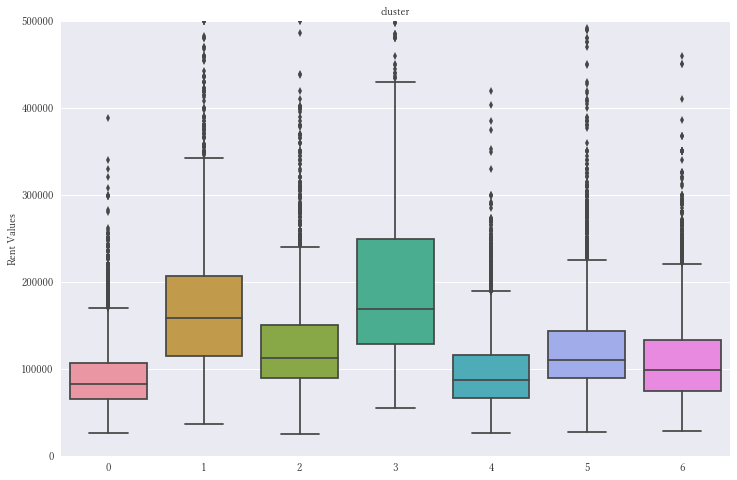

In [54]:
plt.figure(figsize=(12,8))
g = sns.boxplot(x='cluster', y='target', data=train)
g.set_title('cluster', fontsize=10)
g.set_xlabel("", fontsize=10)
g.set_ylabel("Rent Values", fontsize=10)
g.set_ylim(0,500000)

In [60]:
train.head()

id  target                                             access floor_plan  \
0   1   75000  都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...         1K   
1   2   76000  都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...         1R   
2   3  110000  京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...         1K   
3   4  150000  総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...       2LDK   
4   5   74000  京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...        2DK   

       age direction     area     Floor  \
0    9年9ヶ月        南東  20.01m2   1階／12階建   
1  44年10ヶ月       NaN   16.5m2   5階／10階建   
2    8年6ヶ月         南  22.05m2  12階／15階建   
3   29年4ヶ月         南  60.48m2    3階／4階建   
4   31年7ヶ月         南  39.66m2    1階／2階建   

                                         Bath_Toilet  \
0   専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座   
1                              専用トイレ／\tシャワー／\t温水洗浄便座   
2  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...   
3     専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立   
4               専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能   

                           kitchen                             broadcast  \
0  ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯    インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ   
1          ガスコンロ／\tシステムキッチン\t／\t給湯                             インターネット対応   
2  ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯  インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ   
3                       ガスコンロ／\t給湯                    インターネット対応／\t光ファイバー   
4                      給湯／\t独立キッチン                                   NaN   

                                          facilities  \
0  エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...   
1  エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...   
2  エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...   
3  エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...   
4                バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水   

                                             parking  \
0                                            駐輪場\t空有   
1                         駐輪場\t空有\t駐車場\t無\tバイク置き場\t無   
2  駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m   
3                          駐車場\t無\t駐輪場\t無\tバイク置き場\t無   
4    駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無   

                                                 env     structure  \
0  【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...  RC（鉄筋コンクリート）   
1                                       【スーパー】 1283m           鉄骨造   
2  【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m  RC（鉄筋コンクリート）   
3  【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...  RC（鉄筋コンクリート）   
4  【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...            木造   

                   C_year city  cluster   x   y  
0                     2年間   北区        4 NaN NaN  
1                     2年間  中央区        1 NaN NaN  
2                     2年間  渋谷区        1 NaN NaN  
3  2年間\t※この物件は\t定期借家\tです。  杉並区        0 NaN NaN  
4                     2年間  葛飾区        4 NaN NaN

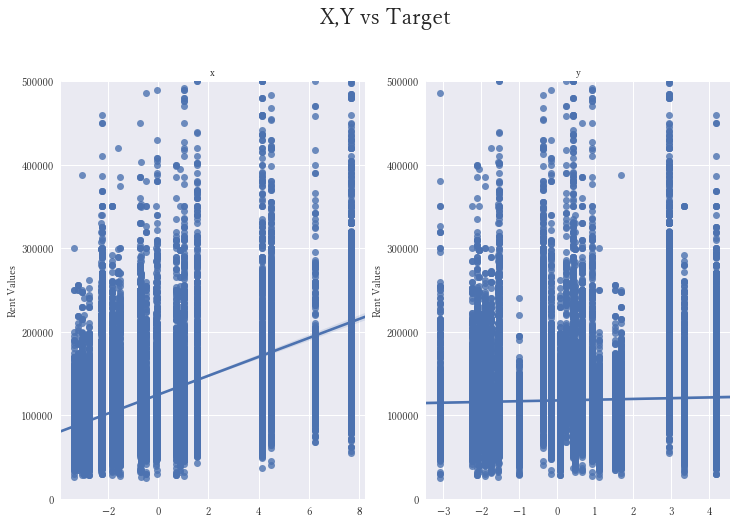

In [63]:
plt.figure(figsize=(12,8))
plt.suptitle('X,Y vs Target', fontsize=22)
for i,f in enumerate(['x','y']):
    plt.subplot(1,2,i+1)
    g = sns.regplot(x=f, y='target', data=train)
    g.set_title(f, fontsize=10)
    g.set_xlabel("", fontsize=10)
    g.set_ylabel("Rent Values", fontsize=10)
    g.set_ylim(0,500000)
    plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()